# Прогнозирование большого количества рядов

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому вы не сможете вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, вам предстоит кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера.

Результатом этой недели будут построенные с помощью ARIMA почасовые прогнозы количества поездок для всех географических зон Нью-Йорка. Модель, которую мы строим, должна делать почасовые прогнозы для всех выбранных непустых ячеек на 6 часов вперёд. Качество модели мы будем оценивать с помощью среднего абсолютного отклонения от истинного количества поездок

1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D, Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!
6. Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
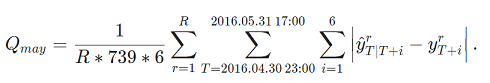
7. Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.
8. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.
9. Загрузите ноутбук в форму.

In [4]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler as scaler
from itertools import product
import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min

import warnings
warnings.simplefilter(action='ignore')

**1.** Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [7]:
nonzero_reg=pd.read_csv("df_reg_mean.csv").iloc[:,1]
reg_index=[int(x) for x in nonzero_reg]

FileNotFoundError: [Errno 2] No such file or directory: 'df_reg_mean.csv'

In [3]:
df_4=pd.read_csv("yellow_tripdata_2016-04.csv-agregated.csv")
df_3=pd.read_csv("yellow_tripdata_2016-03.csv-agregated.csv")
df_2=pd.read_csv("yellow_tripdata_2016-02.csv-agregated.csv")
df_1=pd.read_csv("yellow_tripdata_2016-01.csv-agregated.csv")
data=pd.concat([ df_1,df_2,df_3,df_4], axis=0)

data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
data.index=data.time
df=data.iloc[:,nonzero_reg]
df.head()



1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

**2.** Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [4]:
sc=scaler()
df_s=pd.DataFrame(sc.fit_transform(X=np.array(df)), columns=df.columns)
df_s

1075      1076      1077      1125      1126      1127      1128  \
0     0.534333  0.178299 -0.565388  0.271055  1.423610  0.941333  1.327688   
1     0.823393  1.005639 -0.582598  1.673853  2.292927  1.069294  0.407607   
2     0.797115  0.202995 -1.030077  1.083201  2.180427  1.104839  0.081865   
3    -0.727022 -0.525558 -1.150552 -0.098103  0.738384  0.920006  0.144727   
4    -0.937247 -1.068886 -1.253817 -0.319598 -0.355932 -0.110791 -0.198160   
...        ...       ...       ...       ...       ...       ...       ...   
2899  1.611740  0.980942  1.069631  0.861707  1.689519  1.247018  1.259110   
2900  1.243845  0.968594  0.277938  1.009370  1.127020  1.005314  1.396265   
2901  0.823393  0.314131  0.432834  1.206254  1.413383  1.374979  1.722008   
2902  1.059897 -0.402074  0.036988  0.837096  0.380430  1.076403  2.276342   
2903  0.849671 -0.142759 -0.341648  0.492549  1.065656  1.844169  2.482074   

          1129      1130      1131  ...      1630      1684      1733  \
0     1.324958  1.906912  1.834977  ...  1.551231 -0.883705 -0.571914   
1     0.529828  0.846918  1.255230  ...  5.252950 -0.883705 -0.069239   
2     0.108021 -0.065856  0.095738  ...  9.172418 -0.883705 -0.404356   
3    -0.168335 -0.276172  0.473247  ...  8.954670 -0.883705 -0.571914   
4    -0.051975 -0.314029  0.190115  ...  8.301425 -0.883705 -0.907031   
...        ...       ...       ...  ...       ...       ...       ...   
2899  1.843733  1.784929  1.524880  ... -0.843999 -0.883705 -0.069239   
2900  1.887368  1.881674  1.066476  ... -0.626251 -0.883705 -0.571914   
2901  2.575834  1.843817  0.284492  ... -0.626251 -0.883705 -0.571914   
2902  2.963703  2.171911  0.972098  ... -0.843999 -0.883705 -0.571914   
2903  2.396445  2.209768  0.729414  ... -0.190755 -0.883705 -0.907031   

          1734      1783      2068      2069      2118      2119      2168  
0    -1.047780 -1.251905 -0.786766 -0.681902 -0.821275 -0.855714  0.031380  
1    -1.325716 -1.275832 -1.423829 -1.172000 -1.125258 -1.089383 -0.931147  
2    -1.338951 -1.259881 -1.492701 -1.172000 -0.834492 -1.089383 -1.321360  
3    -1.312481 -1.251905 -1.475483 -1.172000 -1.468890 -1.128328 -1.451432  
4    -1.332334 -1.283807 -1.492701 -1.172000 -1.402807 -1.089383 -1.529474  
...        ...       ...       ...       ...       ...       ...       ...  
2899 -0.333085 -0.629819  0.917809 -0.559377  0.341789  1.169419  0.499636  
2900 -0.405878 -0.964789  0.556233  0.175771  1.319821  0.818915  1.436149  
2901 -0.081619 -0.757427  0.728412  0.788394  0.341789  2.026206  1.358106  
2902  0.183083 -0.653746  0.780066  1.401017  0.870455 -0.232596  0.733765  
2903 -0.048531 -0.861108  0.814502  0.053246  0.645772  1.753592 -0.671004  

[2904 rows x 102 columns]

In [5]:
df_t=df_s.transpose()
df_t.head()

0         1         2         3         4         5         6     \
1075  0.534333  0.823393  0.797115 -0.727022 -0.937247 -1.278864 -1.383977   
1076  0.178299  1.005639  0.202995 -0.525558 -1.068886 -1.377595 -1.291156   
1077 -0.565388 -0.582598 -1.030077 -1.150552 -1.253817 -1.339870 -1.374292   
1125  0.271055  1.673853  1.083201 -0.098103 -0.319598 -1.205576 -1.205576   
1126  1.423610  2.292927  2.180427  0.738384 -0.355932 -1.307067 -1.440022   

          7         8         9     ...      2894      2895      2896  \
1075 -1.331421 -1.094917 -0.989804  ...  2.058469  2.242417  2.689147   
1076 -1.291156 -1.278808 -1.130628  ...  2.326913  2.092295  1.042684   
1077 -1.253817 -1.271027 -1.133342  ...  1.052420  1.104052  0.501677   
1125 -1.254797 -1.131744 -0.910250  ...  0.615602  0.615602  0.221834   
1126 -1.409340 -1.122977 -1.153658  ...  1.116792  1.096338  0.861111   

          2897      2898      2899      2900      2901      2902      2903  
1075  2.163582  2.557756  1.611740  1.243845  0.823393  1.059897  0.849671  
1076  1.289651  1.153819  0.980942  0.968594  0.314131 -0.402074 -0.142759  
1077  0.484466  0.708206  1.069631  0.277938  0.432834  0.036988 -0.341648  
1125  0.763265  1.107812  0.861707  1.009370  1.206254  0.837096  0.492549  
1126  1.556564  1.628155  1.689519  1.127020  1.413383  0.380430  1.065656  

[5 rows x 2904 columns]

**3.** Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

Определим количество кластеров методом локтя

Оптимальное число параметров по методу плеча 6


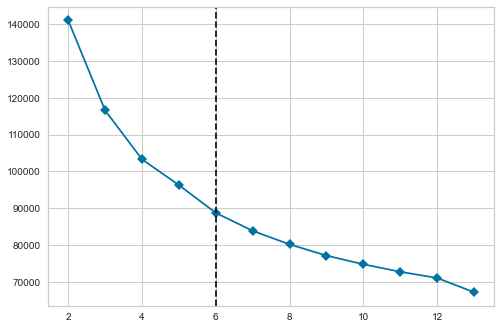

In [6]:
kmeans = KMeans(random_state=1)
kmeans_visualizer = KElbowVisualizer(kmeans, 
                                     k=(2,14), 
                                     metric='distortion',
                                    timings=False).fit(df_t)

print("Оптимальное число параметров по методу плеча %d" % kmeans_visualizer.elbow_value_)

Проверим методом силуэта 

Оптимальное число параметров по методу силуэта 2


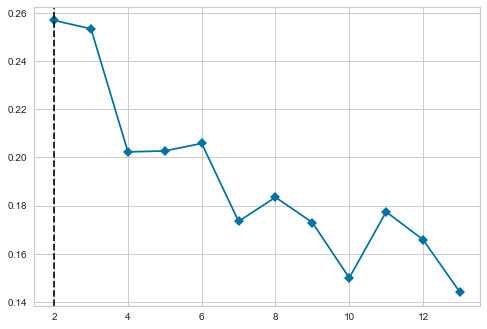

In [7]:
kmeans = KMeans(random_state=1)
kmeans_visualizer = KElbowVisualizer(kmeans, 
                                     k=(2,14), 
                                     metric='silhouette',
                                    timings=False).fit(df_t)

print("Оптимальное число параметров по методу силуэта %d" % kmeans_visualizer.elbow_value_)

Метод силуэта дает оптимальное число кластеров = 2. Также на графике видно пики на позициях 6,8.

Остановим свой выбор и продолжим работу с числом кластеров = 6.

In [8]:
n_clust = 6
km_model = KMeans(n_clusters=n_clust, max_iter=200, random_state=100)
km_model.fit(df_t)

clusters_df= pd.DataFrame(km_model.labels_, 
                          index=reg_index, 
                          columns={'id'})
clusters_df.value_counts()

id
1     27
0     23
3     20
4     17
2      9
5      6
dtype: int64

In [9]:
reg_0 = df_t.iloc[km_model.labels_ == 0].index
reg_1 = df_t.iloc[km_model.labels_ == 1].index
reg_2 = df_t.iloc[km_model.labels_ == 2].index
reg_3 = df_t.iloc[km_model.labels_ == 3].index
reg_4 = df_t.iloc[km_model.labels_ == 4].index
reg_5 = df_t.iloc[km_model.labels_ == 5].index

In [15]:
# Введем функцию для отрисовки графиков по 3 случайным района из региона
import random
def plot_ordinary_values_by_cluster(region):
    plt.figure(figsize=(16, 3*25))
    random_indices = random.choices(region, k=3)
    for (i, num) in  zip(random_indices, np.arange(1,4)):
        plt.subplot(len(region),1,num)
        plt.plot(df_s[str(i)], color='tab:blue')
    plt.show()

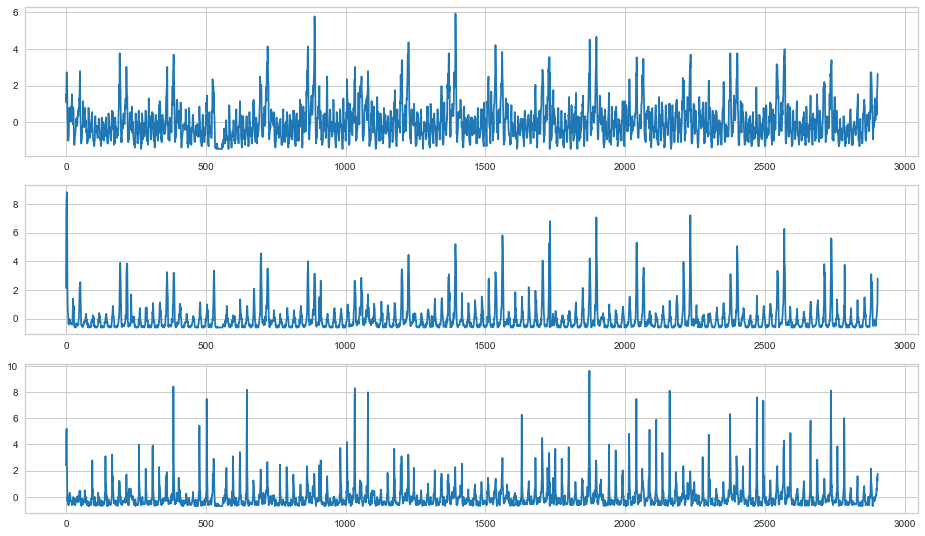

In [57]:
plot_ordinary_values_by_cluster(reg_0)


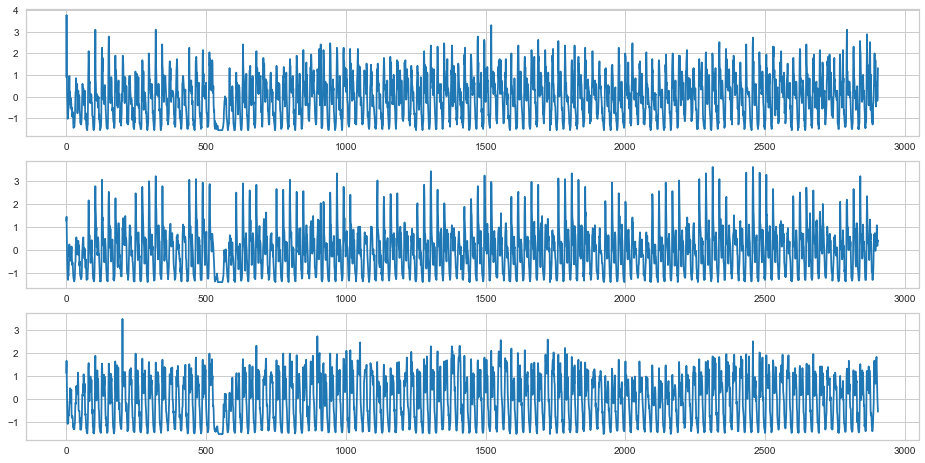

In [58]:
plot_ordinary_values_by_cluster(reg_1)

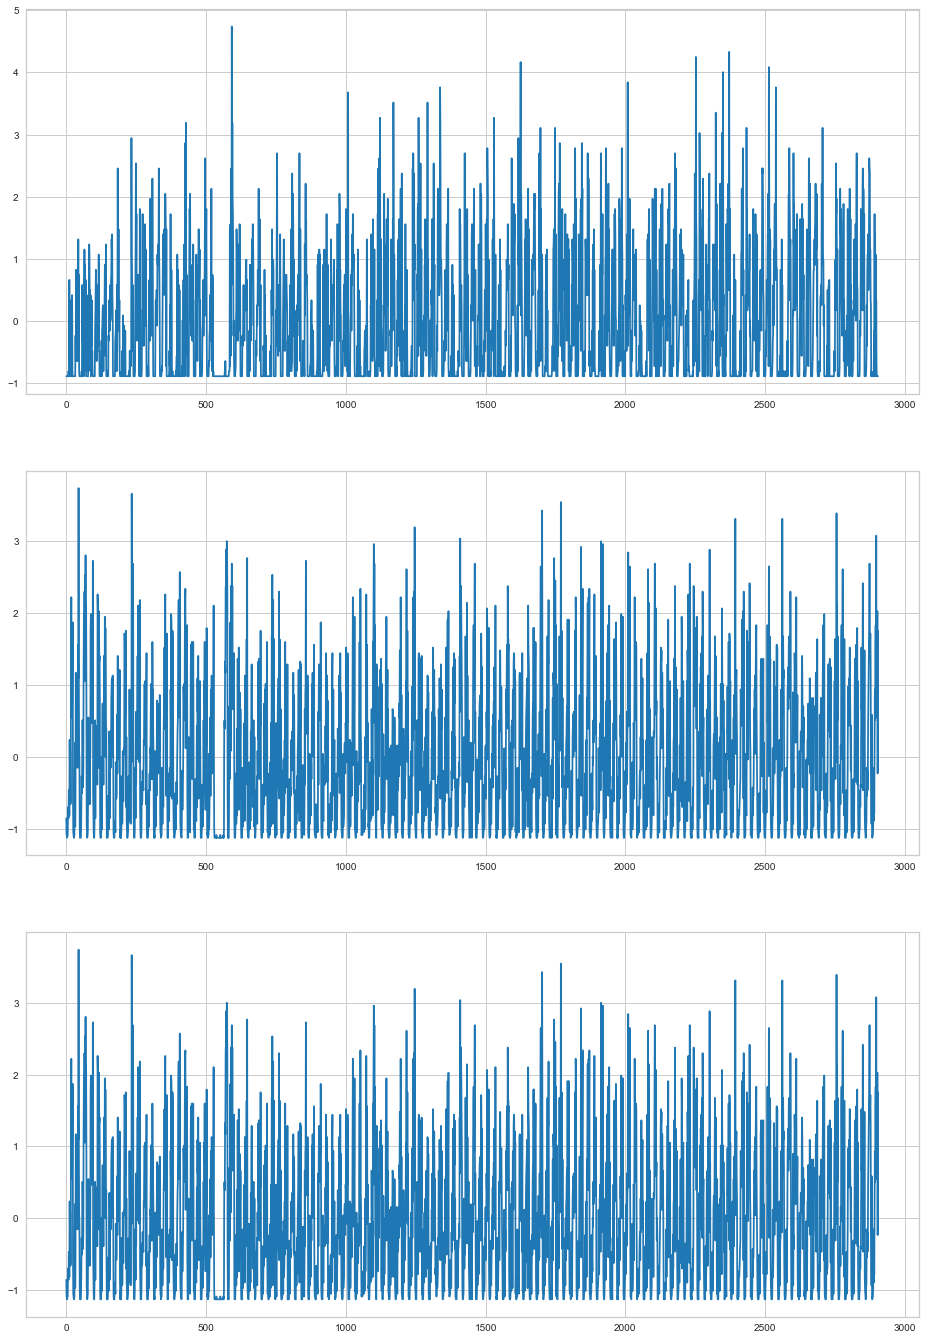

In [59]:
plot_ordinary_values_by_cluster(reg_2)

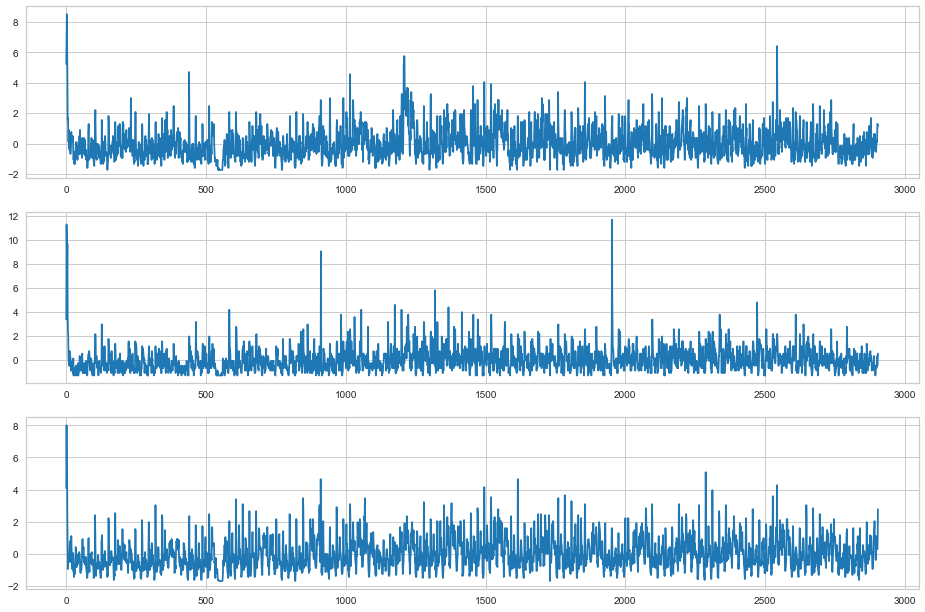

In [60]:
plot_ordinary_values_by_cluster(reg_3)

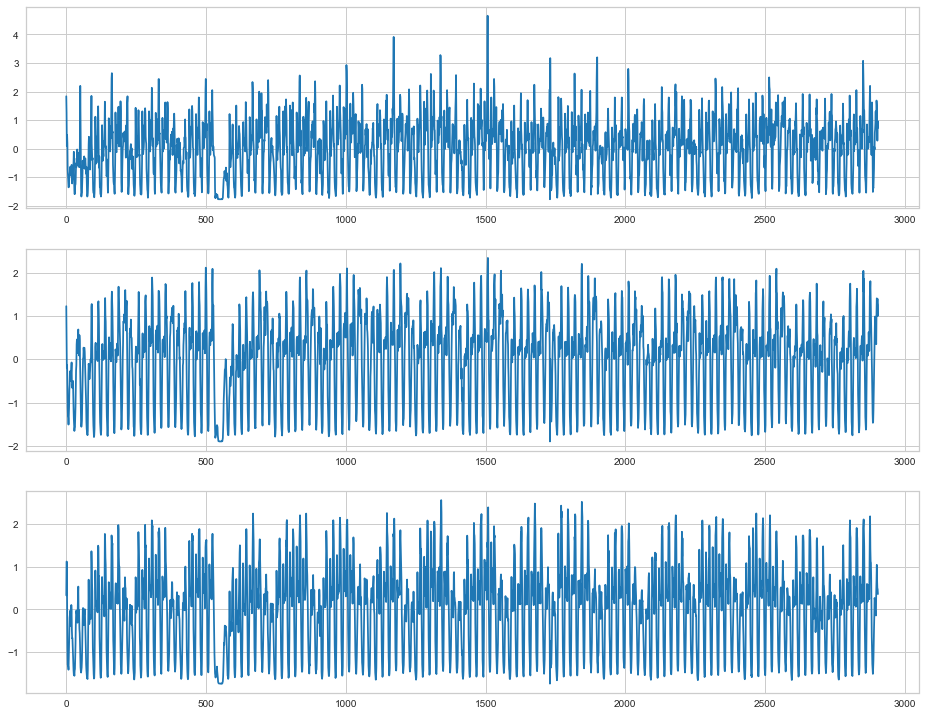

In [61]:
plot_ordinary_values_by_cluster(reg_4)

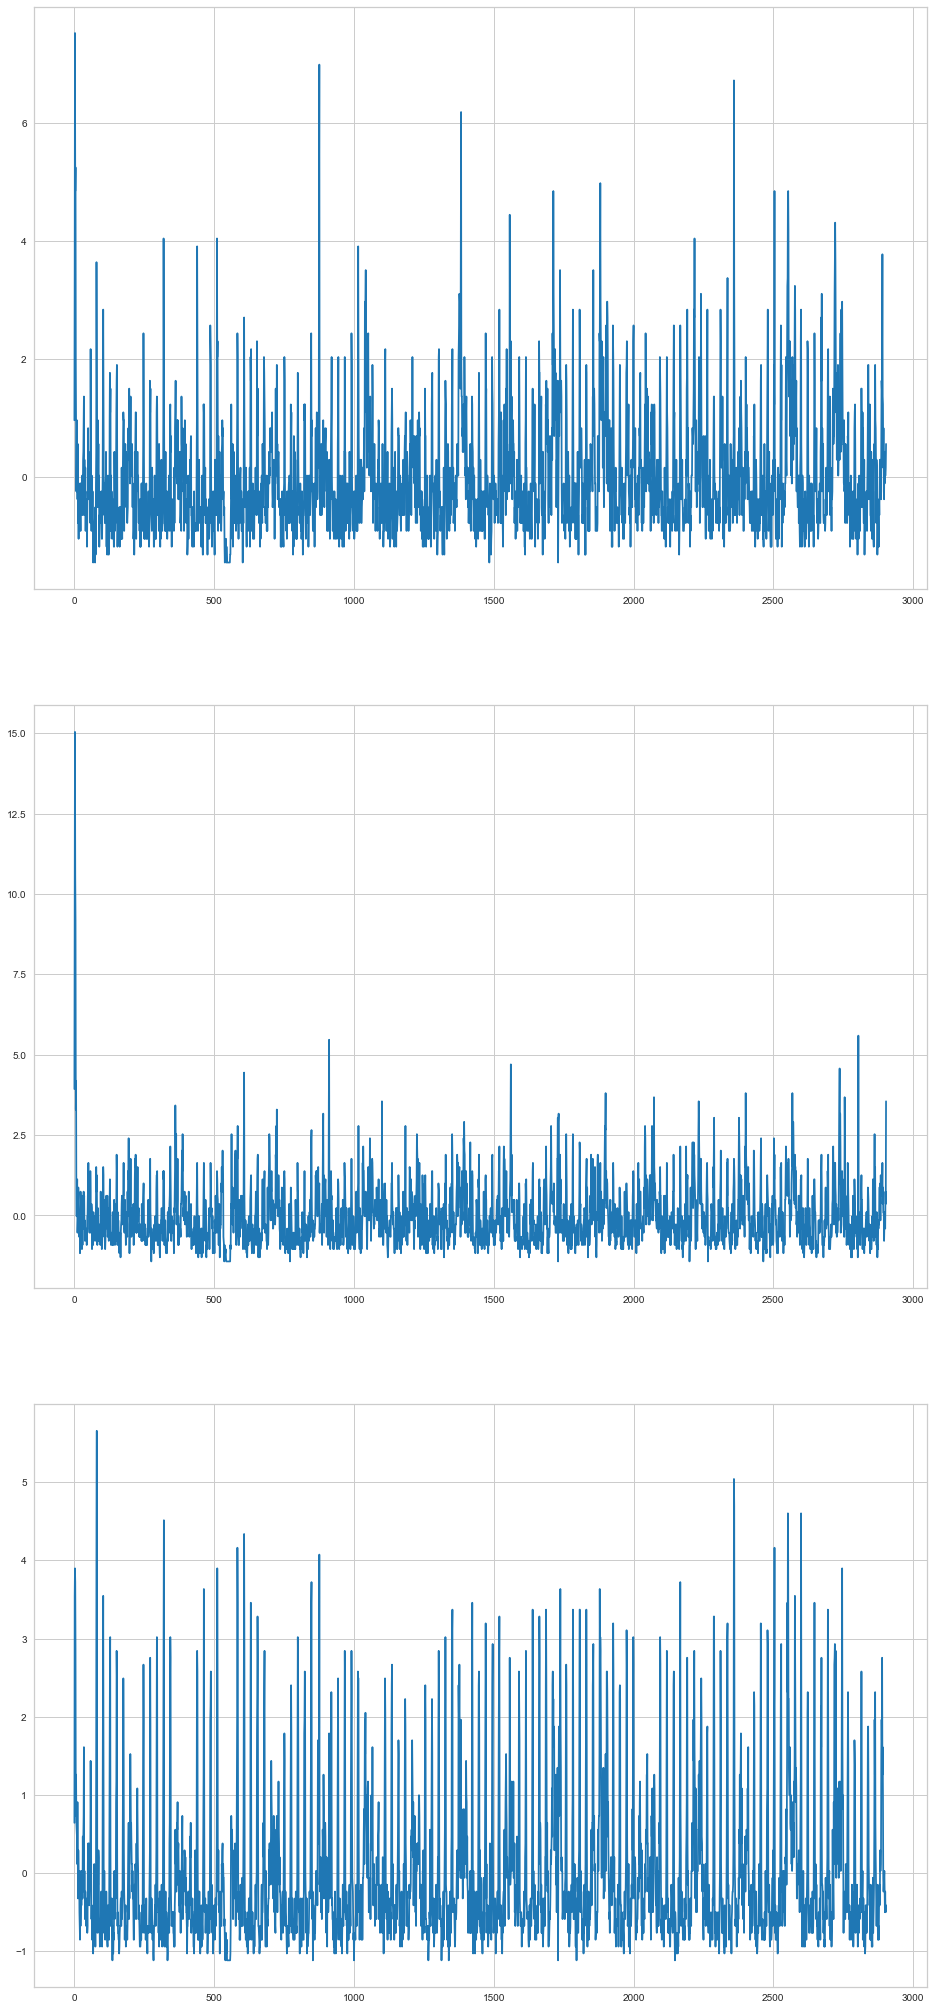

In [63]:
plot_ordinary_values_by_cluster(reg_5)

Посмотрев графики, заметно, что каждая группа имеет свою особенность

**4.** В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

In [10]:
# Ищем в датасете элементы ближайшие к центрам кластеров
closest, _ = pairwise_distances_argmin_min(km_model.cluster_centers_, df_t)
inds=df_t.index[closest]


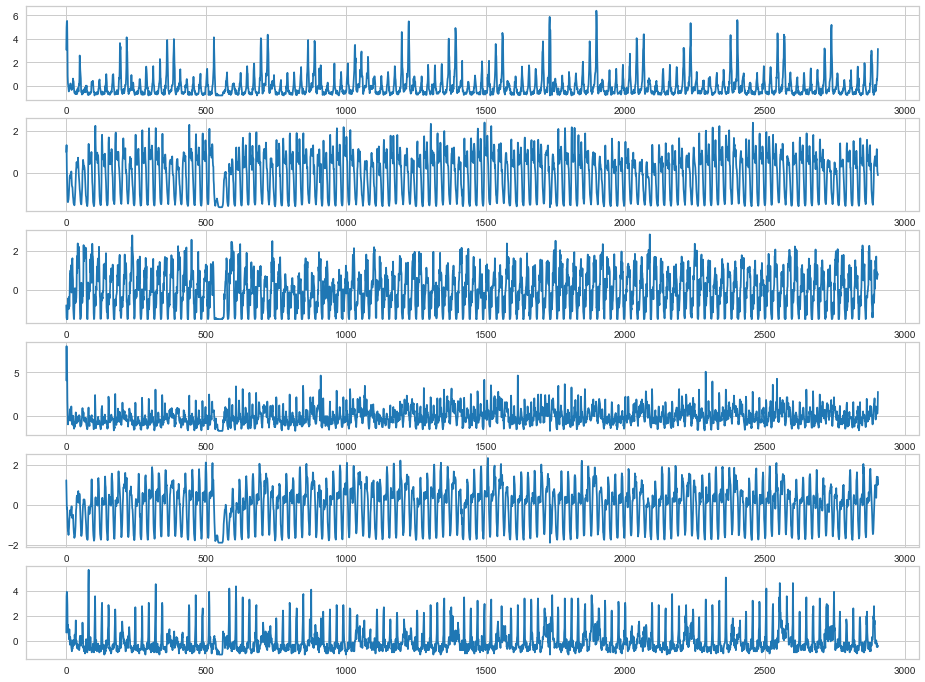

Wall time: 327 ms


In [16]:
%%time
plt.figure(figsize=(16,12))
for i in  range(n_clust):
    plt.subplot(n_clust,1,i+1)
    plt.plot(df_s[inds[i]], color='tab:blue')
    
plt.show()

**5.** Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [43]:

# Создание экзогенных переменных для кластера
def prepair_for_ARIMA(clust,k=50):
    dataset=pd.DataFrame(df[inds[clust]].values,index=df.index, columns={'count'})
    dataset['time']=df.index

    w=168 # длительность недели в часах
    t=np.arange(1, dataset.shape[0]+1)
    dataset['constant']=np.ones(dataset.shape[0])
    for i in range(1,k):
        sin="s"+str(i)
        cos="c"+str(i)
        dataset[sin]=np.sin(2*i*np.pi*t/w)
        dataset[cos]=np.cos(2*i*np.pi*t/w)
    dataset['time']=pd.to_datetime(dataset['time'], format='%Y-%m-%d %H:%M:%S')
 
    model0=sm.OLS(dataset['count'], dataset.drop(['count','time'], axis=1)).fit()
    print(model0.rsquared_adj)
    print(model0.aic)
    
    return(dataset, model0)

# Построение графика для анализа остатков регрессионной модели
def graph_analysis_for_ARIMA(model):
    resid=pd.DataFrame(model.resid, columns={'resid'}) 
    resid['resid_D24'] = resid.resid - resid.resid.shift(24)
    sm.tsa.seasonal_decompose(resid.resid[0:1000], period=24).plot( )
    sm.tsa.seasonal_decompose(resid.resid_D24[25:1000], period=24).plot( )
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    #plt.show()
    plt.figure(figsize=(16,24))
    ax1 = plt.subplot(411)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax1)
    ax2 = plt.subplot(412)
    sm.graphics.tsa.plot_acf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax2)
    ax3 = plt.subplot(413)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=628, ax=ax3)
    ax4 = plt.subplot(414)
    sm.graphics.tsa.plot_pacf(resid['resid_D24'][25:].values.squeeze(), lags=np.arange(0,100), ax=ax4)
    plt.show()
    print('p-value критерия Дики-Фуллера для ряда остатков =', round(adfuller(resid['resid'])[1], 4))
    print('p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  =', round(adfuller(resid['resid_D24'][24:])[1], 4))



In [44]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=50, freq="H"):
    """
    Input:
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year.

    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    """
    ans = []
    for comb in par:
        try:
            model = sm.tsa.statespace.SARIMAX(
                ts,
                exog,
                order=(comb[0], d, comb[1]),
                seasonal_order=(comb[2], D, comb[3], s),
                enforce_stationarity=False,
                enforce_invertibility=False,
                freq=freq,
            )
            output = model.fit(
                maxiter=maxiter, method="nm", disp=-1
            )
            ans.append([comb, output.aic])
            
            print("SARIMAX {} x {}12 : AIC Calculated ={}".format(comb, output.aic))
        except:
            continue

    ans_df = pd.DataFrame(ans, columns=["pqPQ", "aic"])

    return ans_df.sort_values(by=["aic"], ascending=True)[0:10]

0.8212384704484748
22378.583834087603


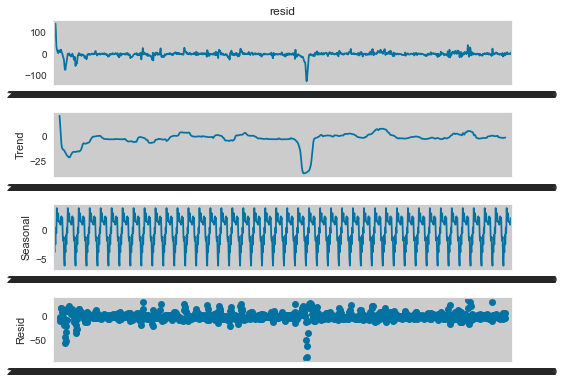

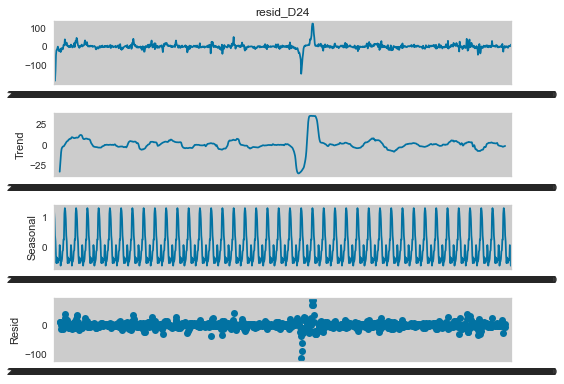

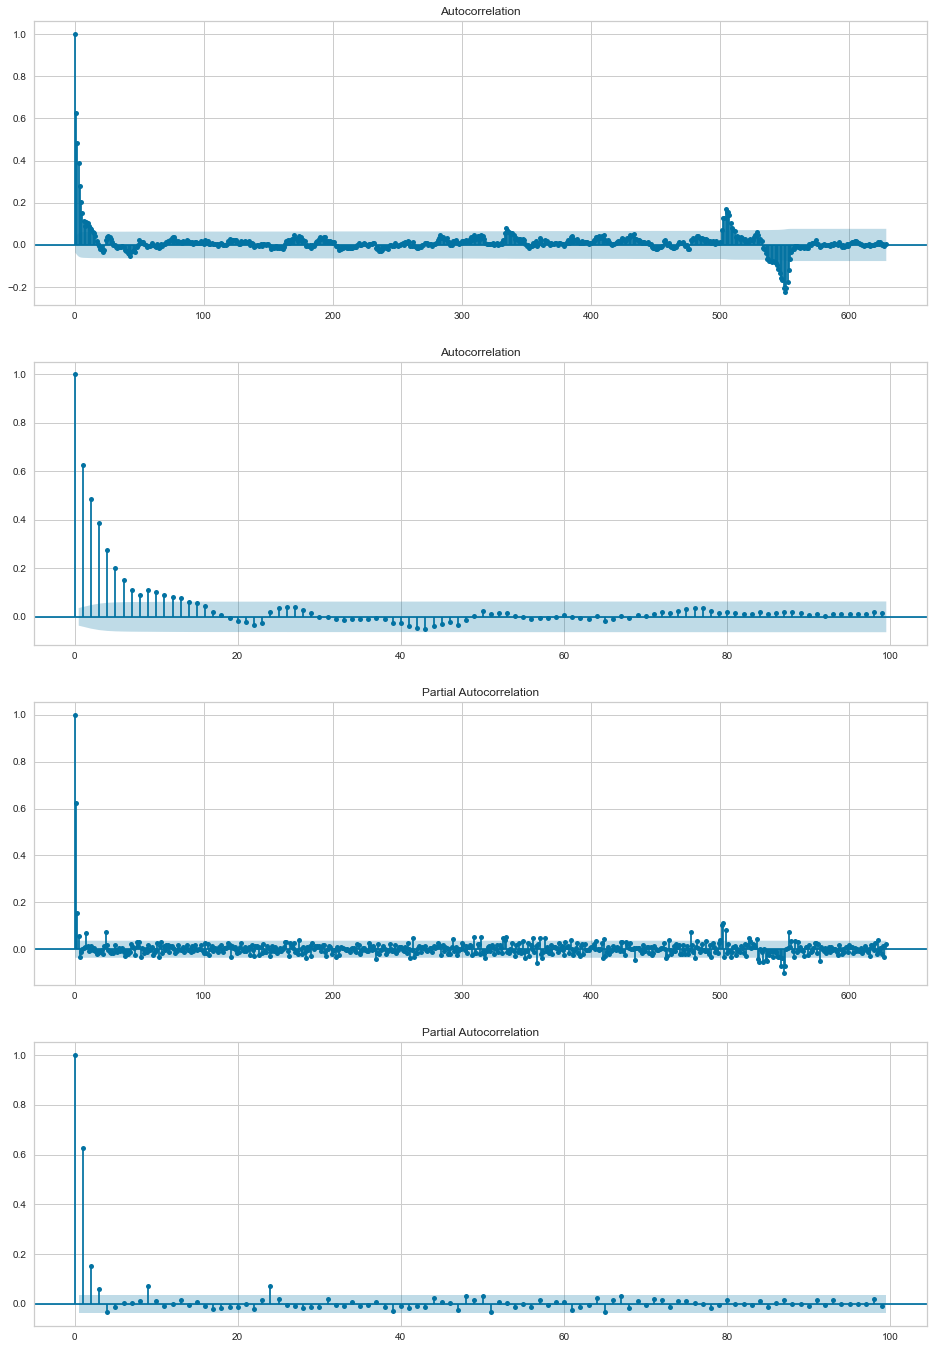

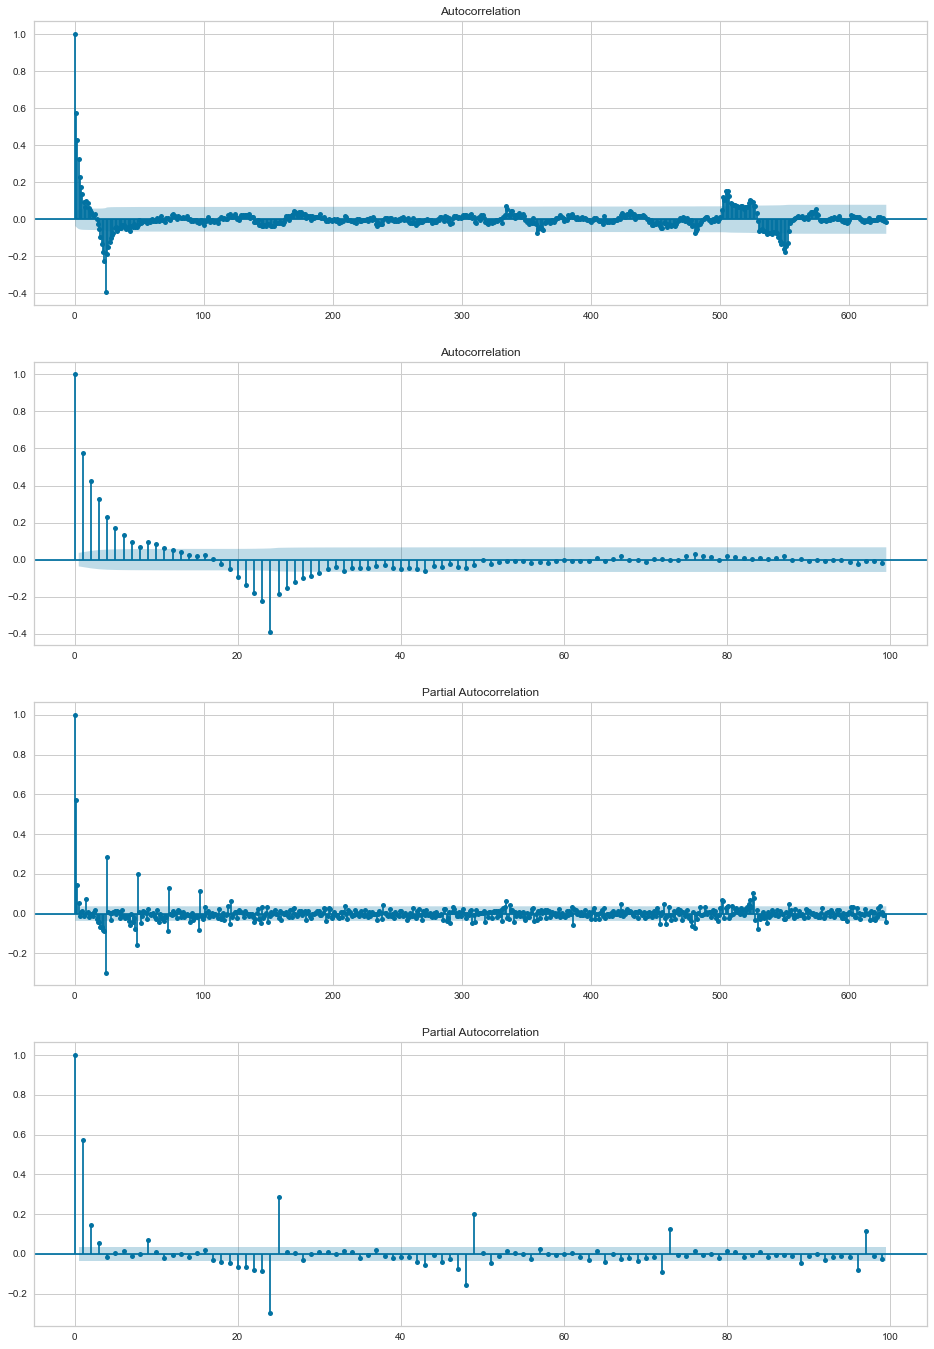

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [84]:
clust0, model0 = prepair_for_ARIMA(0)
graph_analysis_for_ARIMA(model0)

In [93]:
d0=0
D0=0
p0=range(0,5)
q0=range(0,13) 
P0=range(0,2)
Q0=range(0,1)
parameters0 = list(product(p0, q0, P0, Q0))
exogen0 = clust1.drop(['time', 'count'], axis=1)
print(len(parameters0))

130


In [94]:
%%time
sarimax_gridsearch(clust0['count'], exogen0, parameters0, freq='H')

Wall time: 11min 39s


pqPQ           aic
105  (4, 0, 1, 0)  20308.154637
107  (4, 1, 1, 0)  20312.200177
117  (4, 6, 1, 0)  20312.942682
115  (4, 5, 1, 0)  20313.677682
85   (3, 3, 1, 0)  20314.408188
83   (3, 2, 1, 0)  20314.490259
119  (4, 7, 1, 0)  20314.797907
79   (3, 0, 1, 0)  20315.140513
121  (4, 8, 1, 0)  20315.940530
123  (4, 9, 1, 0)  20316.939215

In [ ]:
# Cluster = 0
# 	pqPQ	aic
# 105	(4, 0, 1, 0)	20308.154637
# 107	(4, 1, 1, 0)	20312.200177
# 117	(4, 6, 1, 0)	20312.942682
# 115	(4, 5, 1, 0)	20313.677682
# 85	(3, 3, 1, 0)	20314.408188
# 83	(3, 2, 1, 0)	20314.490259
# 119	(4, 7, 1, 0)	20314.797907
# 79	(3, 0, 1, 0)	20315.140513
# 121	(4, 8, 1, 0)	20315.940530
# 123	(4, 9, 1, 0)	20316.939215

0.9098959033041119
34526.035333160646


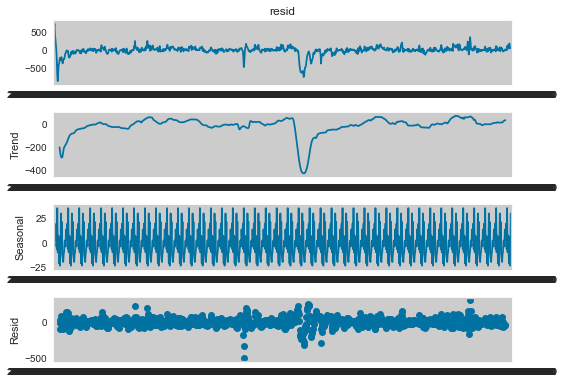

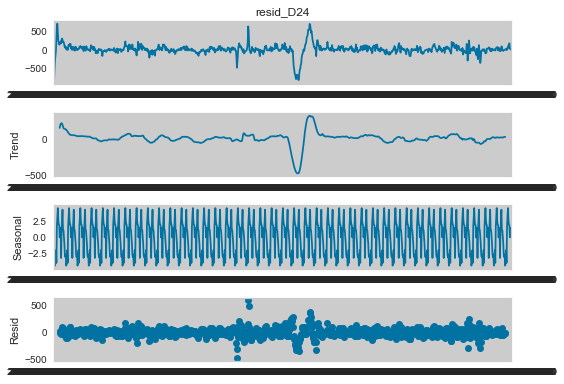

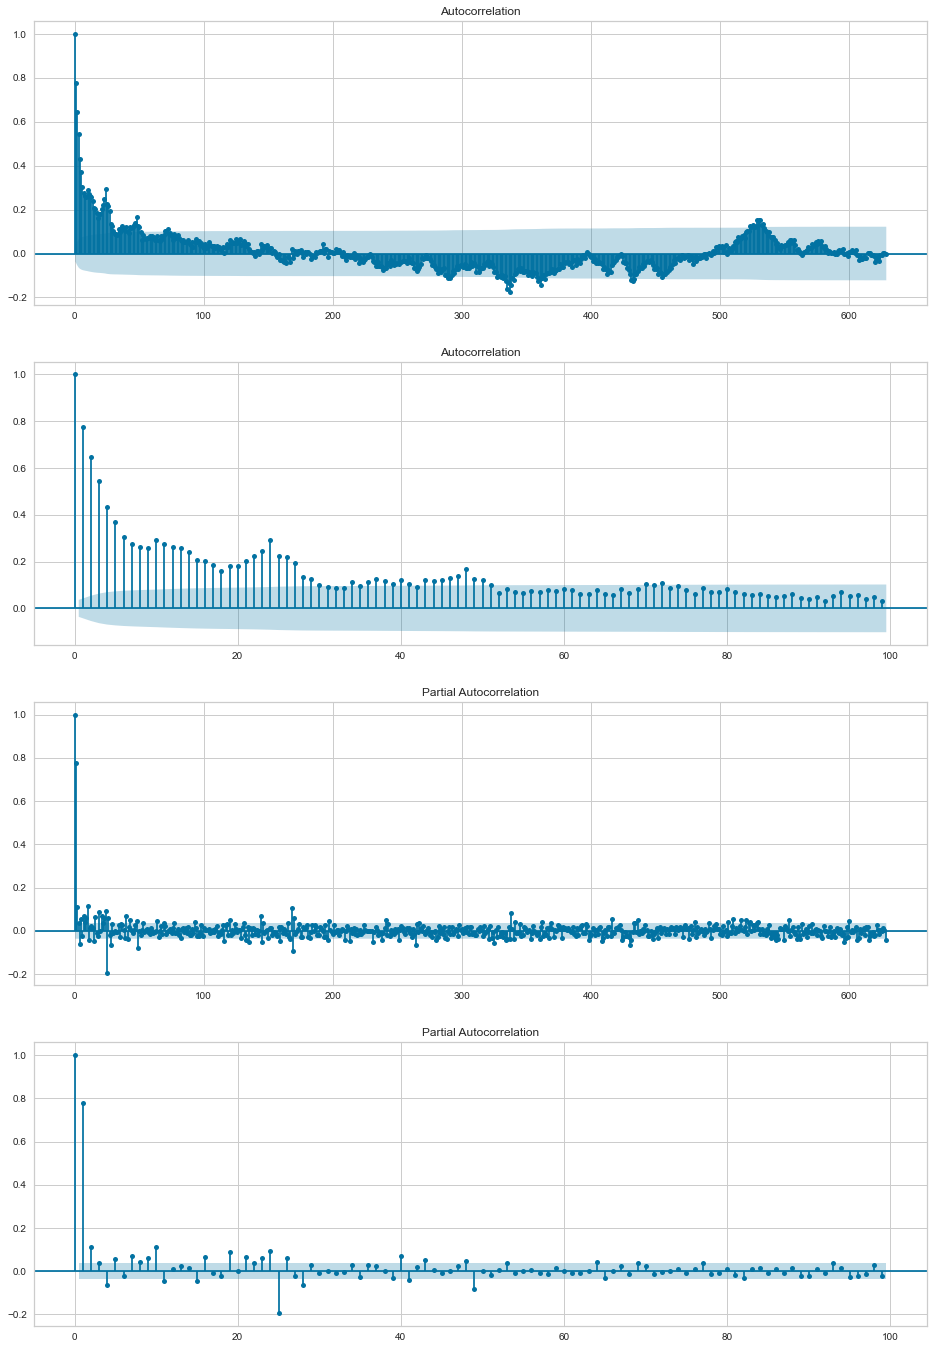

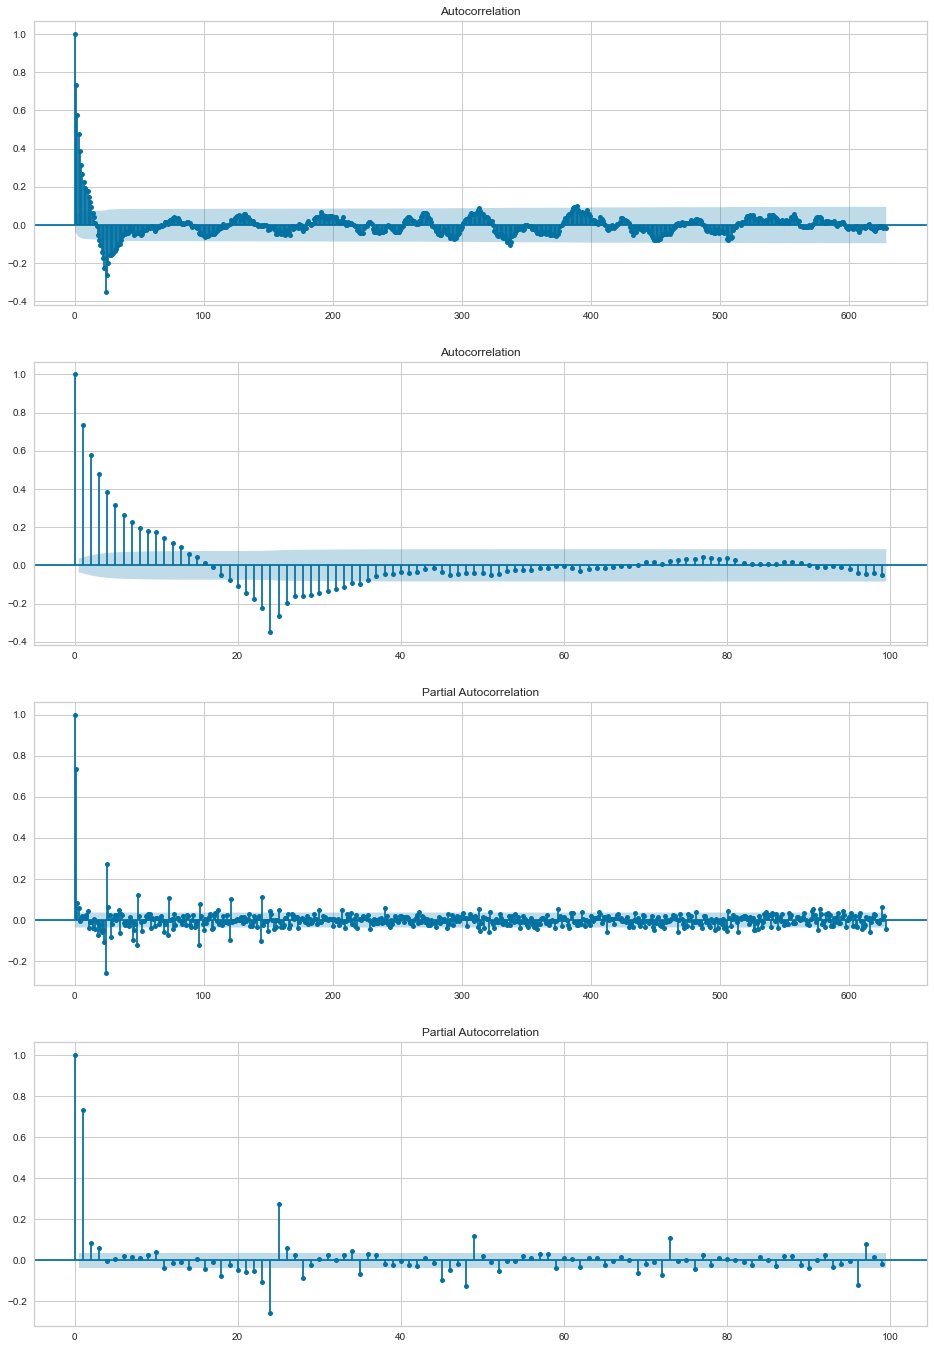

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [85]:
clust1, model1 = prepair_for_ARIMA(1)
graph_analysis_for_ARIMA(model1)

In [98]:
d1=0
D1=0
p1=range(0,3)
q1=range(0,6) 
P1=range(0,3)
Q1=range(0,3)
parameters1 = list(product(p1, q1, P1, Q1))
exogen1 = clust1.drop(['time', 'count'], axis=1)
print(len(parameters1))

162


In [99]:
%%time
sarimax_gridsearch(clust1['count'], exogen1, parameters1, freq='H')

Wall time: 45min 7s


pqPQ           aic
104  (1, 5, 1, 2)  30649.224450
107  (1, 5, 2, 2)  30650.956810
158  (2, 5, 1, 2)  30651.861991
161  (2, 5, 2, 2)  30653.739656
95   (1, 4, 1, 2)  30655.208696
98   (1, 4, 2, 2)  30657.148324
149  (2, 4, 1, 2)  30661.612399
155  (2, 5, 0, 2)  30662.840016
101  (1, 5, 0, 2)  30663.046952
152  (2, 4, 2, 2)  30664.313373

In [ ]:
# Cluster = 1
# 	pqPQ	aic
# 104	(1, 5, 1, 2)	30649.224450
# 107	(1, 5, 2, 2)	30650.956810
# 158	(2, 5, 1, 2)	30651.861991
# 161	(2, 5, 2, 2)	30653.739656
# 95	(1, 4, 1, 2)	30655.208696
# 98	(1, 4, 2, 2)	30657.148324
# 149	(2, 4, 1, 2)	30661.612399
# 155	(2, 5, 0, 2)	30662.840016
# 101	(1, 5, 0, 2)	30663.046952
# 152	(2, 4, 2, 2)	30664.313373

0.8140466250567557
27045.144521823604


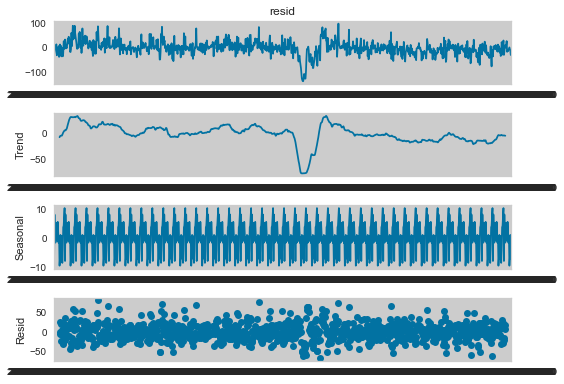

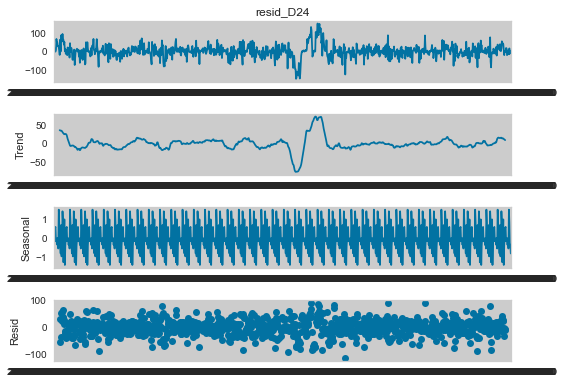

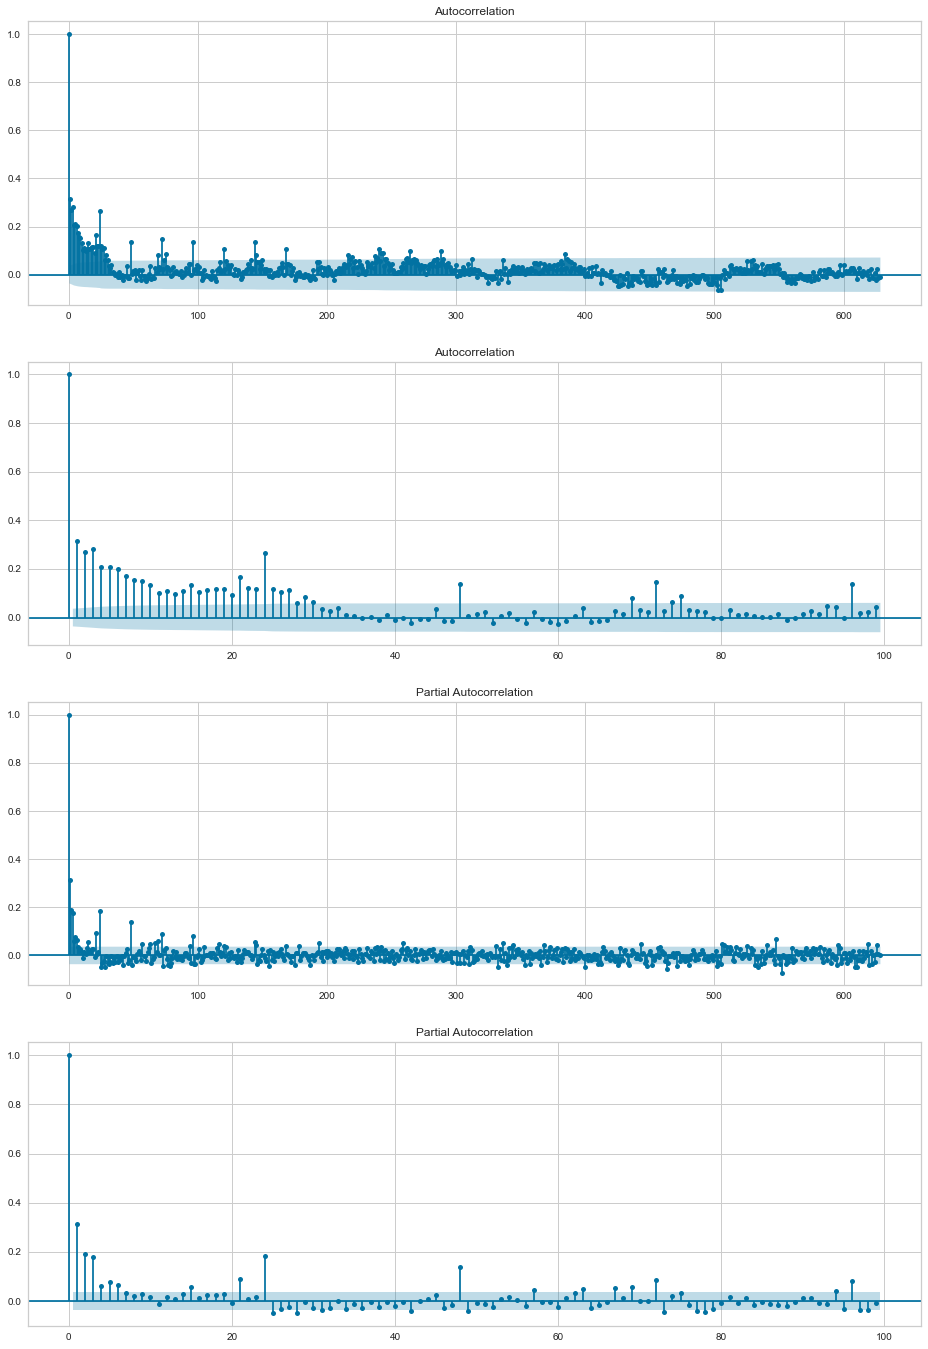

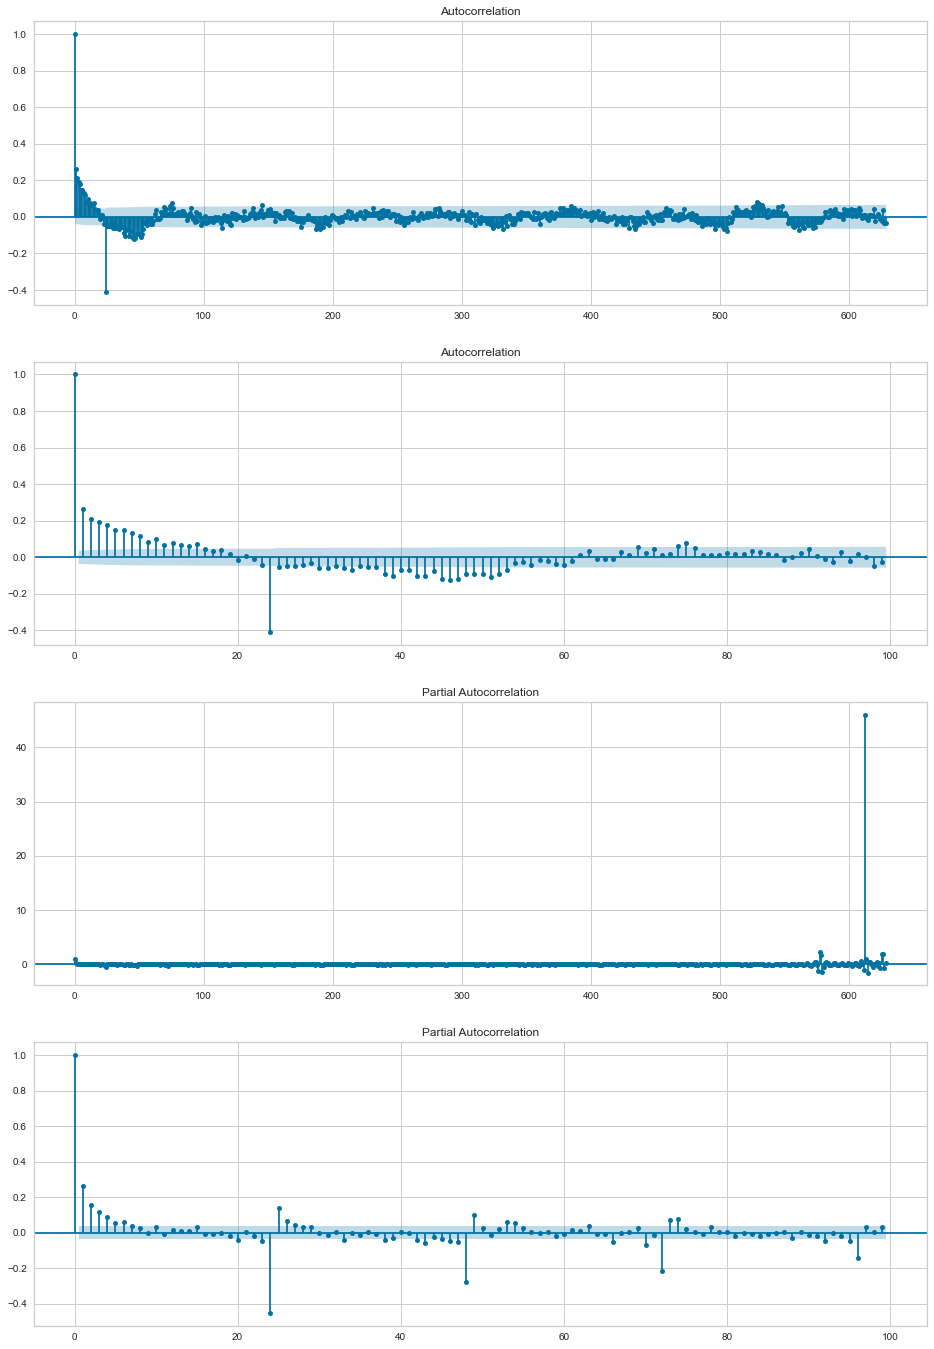

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [51]:
clust2, model2 = prepair_for_ARIMA(2)
graph_analysis_for_ARIMA(model2)

In [52]:
d2=0
D2=0
p2=range(0,2)
q2=range(0,4) 
P2=range(0,2)
Q2=range(0,2)
parameters2 = list(product(p2, q2, P2, Q2))
exogen2 = clust2.drop(['time', 'count'], axis=1)
print(len(parameters2))

32


In [53]:
%%time
sarimax_gridsearch(clust2['count'], exogen2, parameters2, freq='H')

Wall time: 3min 37s


pqPQ           aic
27  (1, 2, 1, 1)  26092.228388
31  (1, 3, 1, 1)  26097.109772
23  (1, 1, 1, 1)  26110.663656
26  (1, 2, 1, 0)  26155.167914
22  (1, 1, 1, 0)  26161.911242
30  (1, 3, 1, 0)  26164.968396
25  (1, 2, 0, 1)  26166.332672
29  (1, 3, 0, 1)  26168.481147
21  (1, 1, 0, 1)  26179.323950
15  (0, 3, 1, 1)  26224.804165

In [ ]:
# Cluster = 2
# pqPQ	aic
# 27	(1, 2, 1, 1)	26092.228388
# 31	(1, 3, 1, 1)	26097.109772
# 23	(1, 1, 1, 1)	26110.663656
# 26	(1, 2, 1, 0)	26155.167914
# 22	(1, 1, 1, 0)	26161.911242
# 30	(1, 3, 1, 0)	26164.968396
# 25	(1, 2, 0, 1)	26166.332672
# 29	(1, 3, 0, 1)	26168.481147
# 21	(1, 1, 0, 1)	26179.323950
# 15	(0, 3, 1, 1)	26224.804165

0.6252688988265934
21624.69143170358


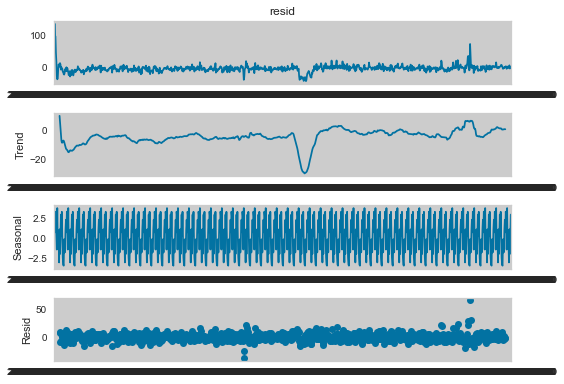

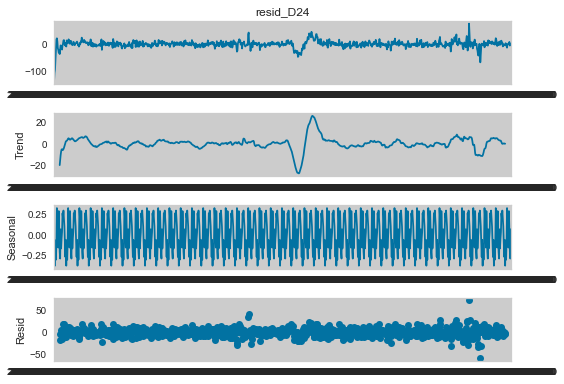

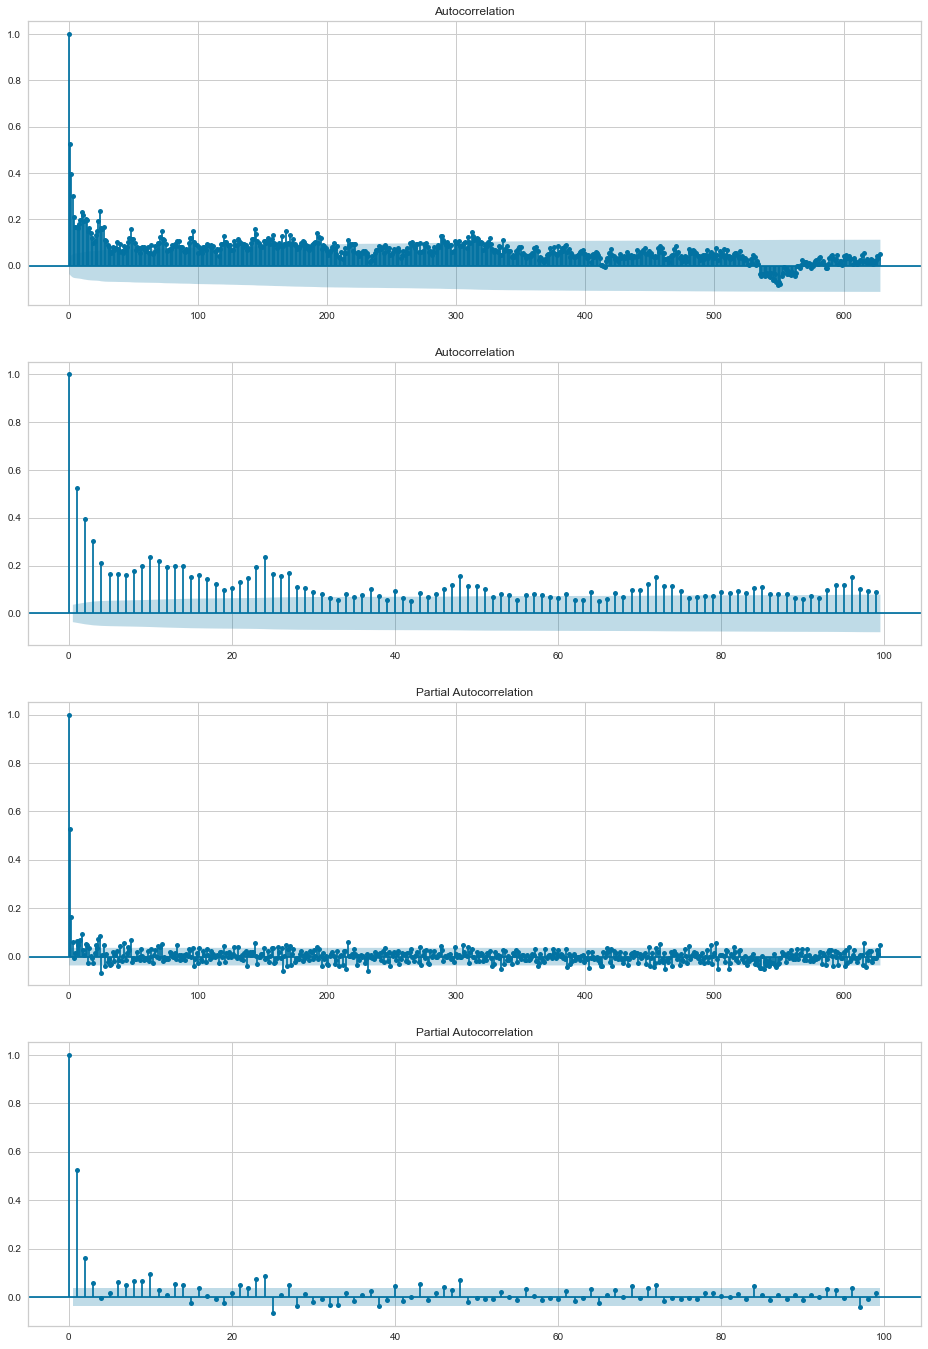

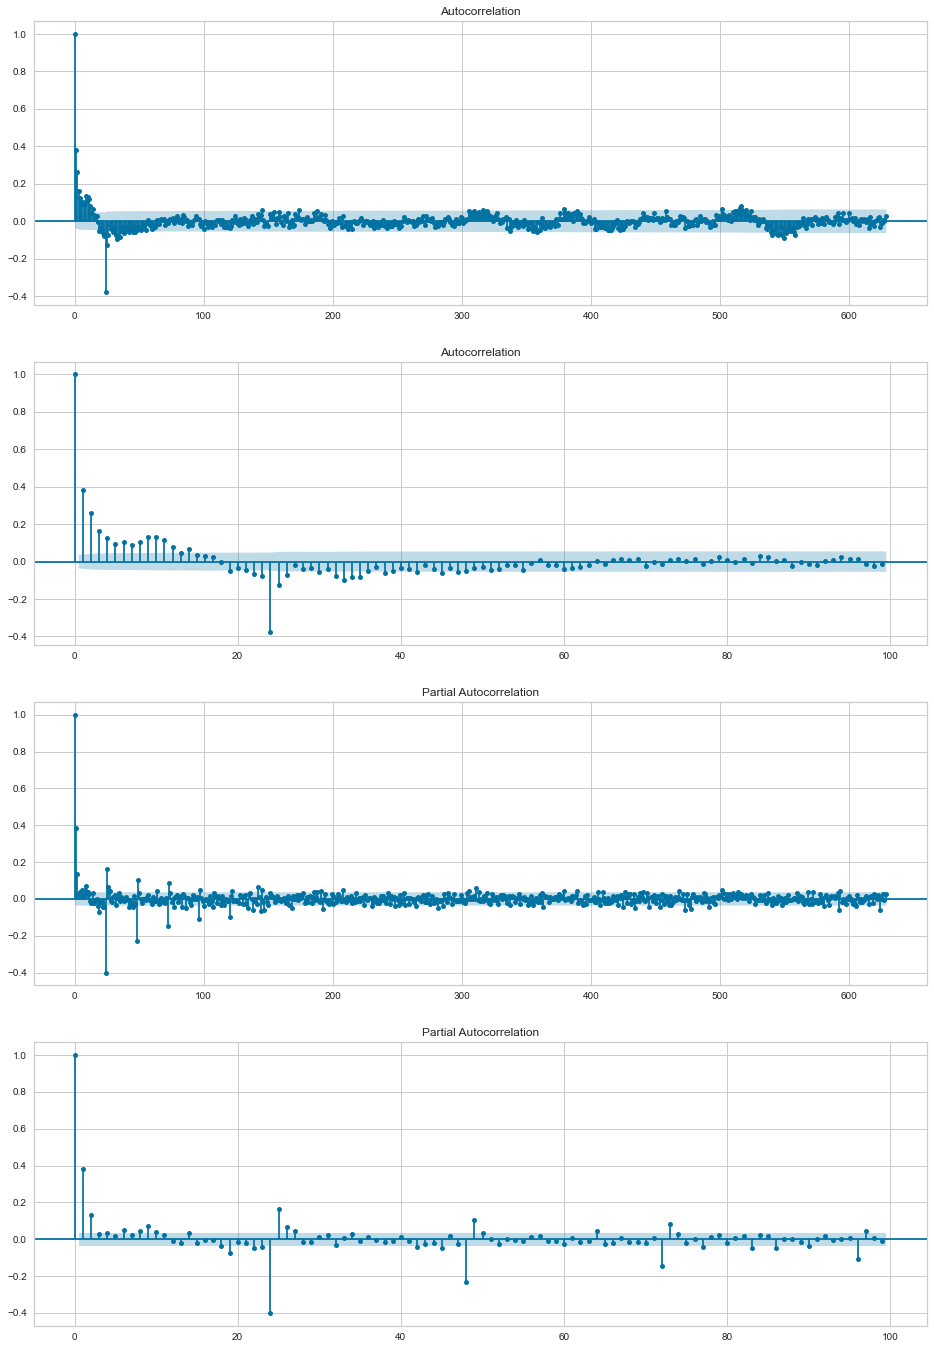

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [43]:
clust3, model3 = prepair_for_ARIMA(3)
graph_analysis_for_ARIMA(model3)

In [44]:
d3=0
D3=0
p3=range(0,3)
q3=range(0,3) 
P3=range(0,1)
Q3=range(0,1)
parameters3 = list(product(p3, q3, P3, Q3))
exogen3 = clust3.drop(['time', 'count'], axis=1)
print(len(parameters3))

9


In [45]:
%%time
sarimax_gridsearch(clust3['count'], exogen3, parameters3, freq='H')

Wall time: 10.1 s


pqPQ           aic
4  (1, 1, 0, 0)  20298.966357
5  (1, 2, 0, 0)  20300.629789
7  (2, 1, 0, 0)  20301.945910
6  (2, 0, 0, 0)  20340.397119
2  (0, 2, 0, 0)  20578.789489
3  (1, 0, 0, 0)  20608.191648
1  (0, 1, 0, 0)  20801.155031
8  (2, 2, 0, 0)  21018.457216
0  (0, 0, 0, 0)  41253.874421

In [ ]:
# cluster = 3
# 4	(1, 1, 0, 0)	20298.966357
# 5	(1, 2, 0, 0)	20300.629789
# 7	(2, 1, 0, 0)	20301.945910
# 6	(2, 0, 0, 0)	20340.397119
# 2	(0, 2, 0, 0)	20578.789489
# 3	(1, 0, 0, 0)	20608.191648
# 1	(0, 1, 0, 0)	20801.155031
# 8	(2, 2, 0, 0)	21018.457216
# 0	(0, 0, 0, 0)	41253.874421

0.8871069033000636
35085.35205624103


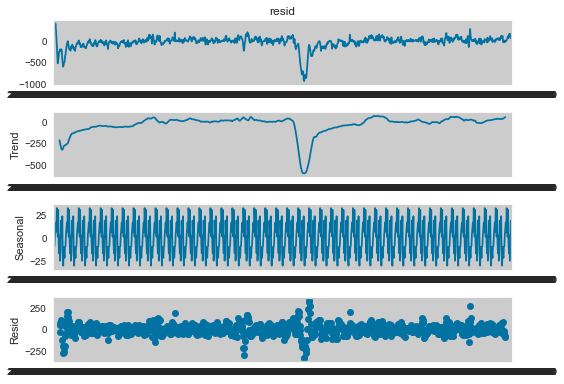

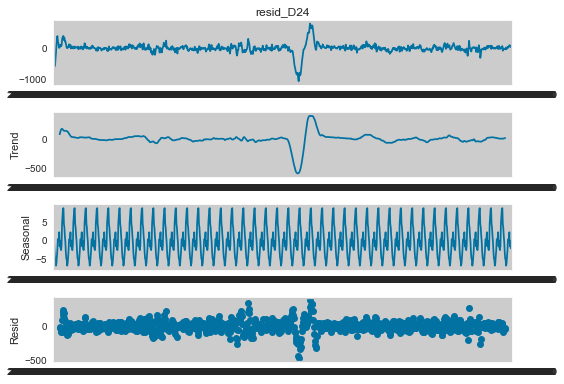

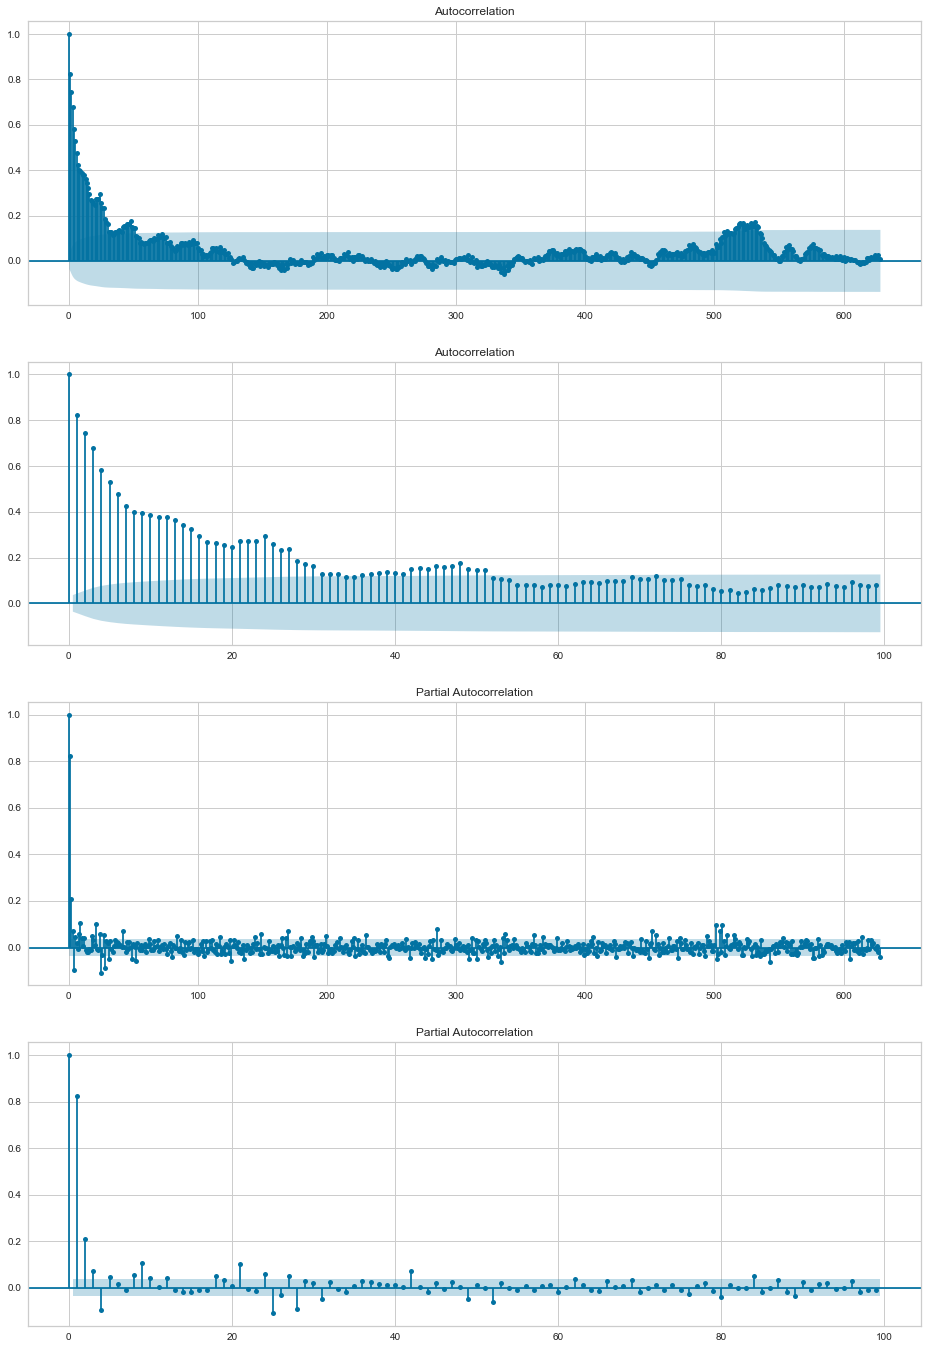

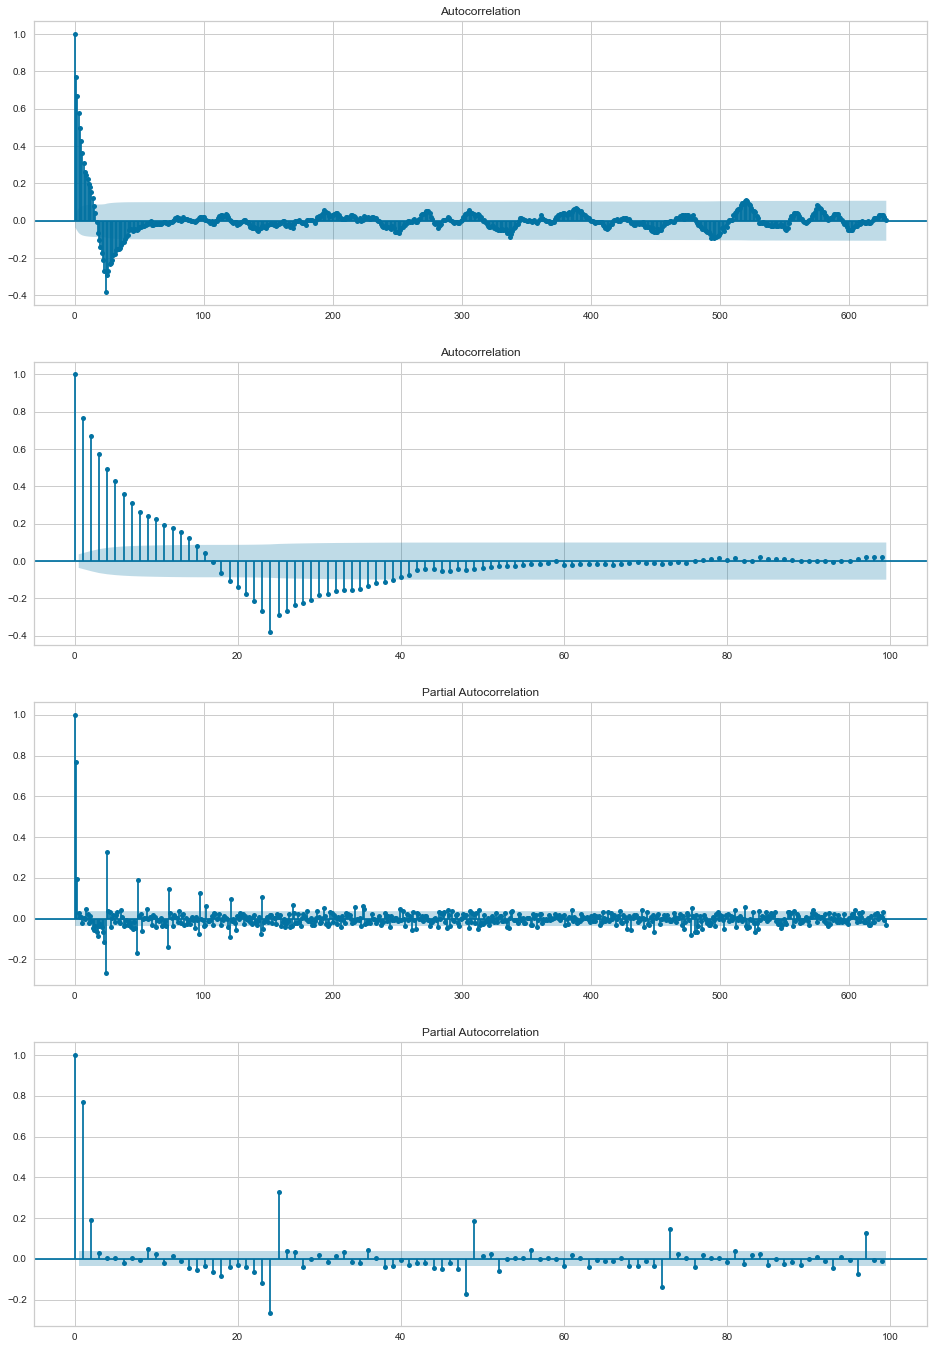

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [30]:
clust4, model4 = prepair_for_ARIMA(4)
graph_analysis_for_ARIMA(model4)

In [32]:
d4=0
D4=0
p4=range(0,5)
q4=range(0,8) 
P4=range(0,2)
Q4=range(0,3)
parameters4 = list(product(p4, q4, P4, Q4))
exogen4 = clust4.drop(['time', 'count'], axis=1)
print(len(parameters4))

240


In [33]:
%%time
sarimax_gridsearch(clust4['count'], exogen4, parameters4, freq='H')

Wall time: 54min 41s


pqPQ           aic
95   (1, 7, 1, 2)  30779.020827
143  (2, 7, 1, 2)  30779.926359
191  (3, 7, 1, 2)  30781.723514
239  (4, 7, 1, 2)  30794.186257
92   (1, 7, 0, 2)  30795.452389
140  (2, 7, 0, 2)  30796.226693
233  (4, 6, 1, 2)  30797.326998
188  (3, 7, 0, 2)  30798.055839
185  (3, 6, 1, 2)  30802.741694
89   (1, 6, 1, 2)  30803.321034

In [ ]:
# Cluster = 4
# 95	(1, 7, 1, 2)	30779.020827
# 143	(2, 7, 1, 2)	30779.926359
# 191	(3, 7, 1, 2)	30781.723514
# 239	(4, 7, 1, 2)	30794.186257
# 92	(1, 7, 0, 2)	30795.452389
# 140	(2, 7, 0, 2)	30796.226693
# 233	(4, 6, 1, 2)	30797.326998
# 188	(3, 7, 0, 2)	30798.055839
# 185	(3, 6, 1, 2)	30802.741694
# 89	(1, 6, 1, 2)	30803.321034

0.7559721781746348
18362.299650414298


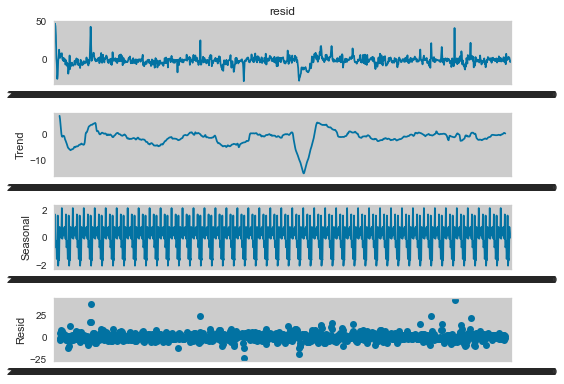

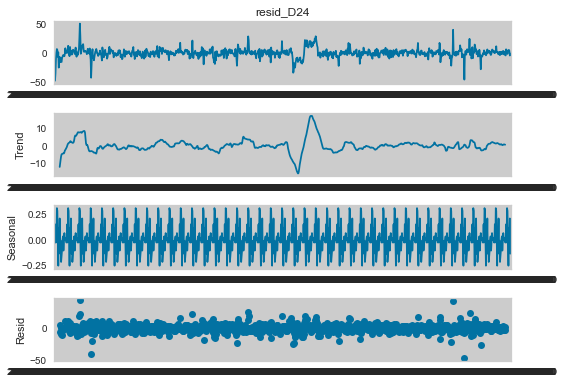

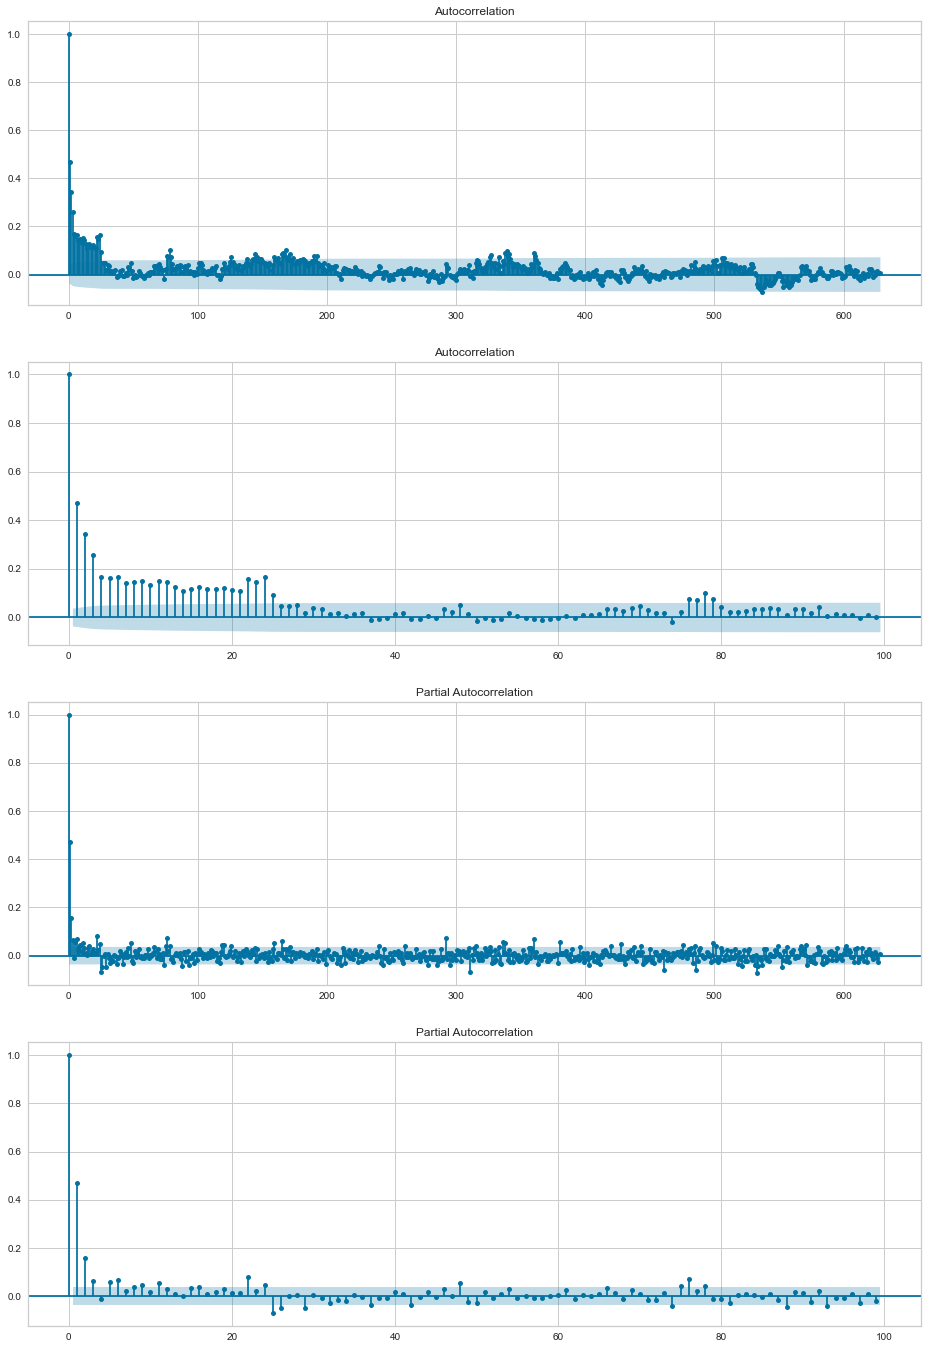

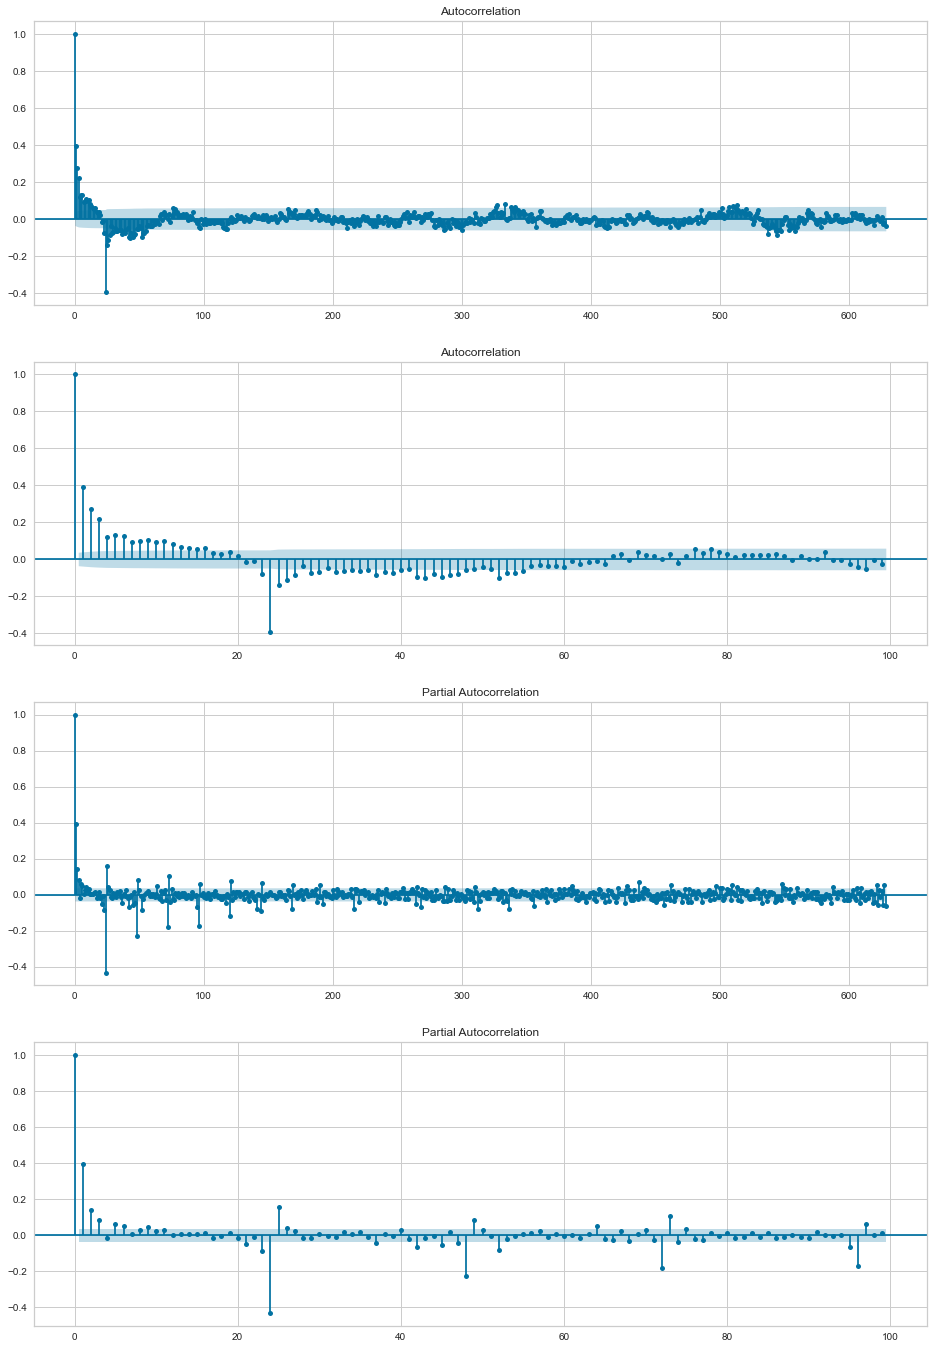

p-value критерия Дики-Фуллера для ряда остатков = 0.0
p-value критерия Дики-Фуллера для ряда остатоков после сезонного дифференцирования  = 0.0


In [34]:
clust5, model5 = prepair_for_ARIMA(5)
graph_analysis_for_ARIMA(model5)

In [35]:
d5=0
D5=0
p5=range(0,4)
q5=range(0,4) 
P5=range(0,3)
Q5=range(0,2)
parameters5 = list(product(p5, q5, P5, Q5))
exogen5 = clust5.drop(['time', 'count'], axis=1)
print(len(parameters5))

96


In [36]:
%%time
sarimax_gridsearch(clust5['count'], exogen5, parameters5, freq='H')

Wall time: 20min 8s


pqPQ           aic
71  (2, 3, 2, 1)  17016.323262
47  (1, 3, 2, 1)  17016.524192
95  (3, 3, 2, 1)  17017.820762
70  (2, 3, 2, 0)  17019.656790
46  (1, 3, 2, 0)  17019.852746
94  (3, 3, 2, 0)  17021.063106
77  (3, 0, 2, 1)  17032.250726
59  (2, 1, 2, 1)  17032.745306
41  (1, 2, 2, 1)  17033.919844
40  (1, 2, 2, 0)  17034.491769

In [55]:
# Cluster = 5
# 	pqPQ	aic
# 71	(2, 3, 2, 1)	17016.323262
# 47	(1, 3, 2, 1)	17016.524192
# 95	(3, 3, 2, 1)	17017.820762
# 70	(2, 3, 2, 0)	17019.656790
# 46	(1, 3, 2, 0)	17019.852746
# 94	(3, 3, 2, 0)	17021.063106
# 77	(3, 0, 2, 1)	17032.250726
# 59	(2, 1, 2, 1)	17032.745306
# 41	(1, 2, 2, 1)	17033.919844
# 40	(1, 2, 2, 0)	17034.491769

----

**6.** Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по предложенному функционалу

In [11]:
# Формирование датасета с маем и июнем

df_5=pd.read_csv("yellow_tripdata_2016-05.csv-agregated.csv")
df_6=pd.read_csv("yellow_tripdata_2016-06.csv-agregated.csv")
df_5.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_6.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df_5.index=df_5.time
df_6.index=df_6.time
df_5=df_5.iloc[:,nonzero_reg]
df_6=df_6.iloc[:,nonzero_reg]
df_large=pd.concat([ df,df_5,df_6], axis=0)
df_large.head()

1075   1076  1077   1125   1126   1127   1128   1129  \
time                                                                        
2016-01-01 00:00:00  80.0  144.0  50.0   77.0  319.0  402.0  531.0  617.0   
2016-01-01 01:00:00  91.0  211.0  49.0  134.0  404.0  420.0  370.0  453.0   
2016-01-01 02:00:00  90.0  146.0  23.0  110.0  393.0  425.0  313.0  366.0   
2016-01-01 03:00:00  32.0   87.0  16.0   62.0  252.0  399.0  324.0  309.0   
2016-01-01 04:00:00  24.0   43.0  10.0   53.0  145.0  254.0  264.0  333.0   

                      1130   1131  ...  1630  1684  1733  1734  1783  2068  \
time                               ...                                       
2016-01-01 00:00:00  846.0  267.0  ...  12.0   0.0   2.0  44.0   5.0  41.0   
2016-01-01 01:00:00  594.0  224.0  ...  29.0   0.0   5.0   2.0   2.0   4.0   
2016-01-01 02:00:00  377.0  138.0  ...  47.0   0.0   3.0   0.0   4.0   0.0   
2016-01-01 03:00:00  327.0  166.0  ...  46.0   0.0   2.0   4.0   5.0   1.0   
2016-01-01 04:00:00  318.0  145.0  ...  43.0   0.0   0.0   1.0   1.0   0.0   

                     2069  2118  2119  2168  
time                                         
2016-01-01 00:00:00   4.0  70.0   7.0  66.0  
2016-01-01 01:00:00   0.0  47.0   1.0  29.0  
2016-01-01 02:00:00   0.0  69.0   1.0  14.0  
2016-01-01 03:00:00   0.0  21.0   0.0   9.0  
2016-01-01 04:00:00   0.0  26.0   1.0   6.0  

[5 rows x 102 columns]

In [12]:
# Подготовка экзогенных переменных для мая и июня

t = np.arange(1, df_large.shape[0]+1)
num_furrier = 50
w=168 # длительность недели в часах

exogen_furrier = pd.DataFrame()
for i in range(1,num_furrier):
        sin="s"+str(i)
        cos="c"+str(i)
        exogen_furrier[sin]=np.sin(2*i*np.pi*t/w)
        exogen_furrier[cos]=np.cos(2*i*np.pi*t/w)
exogen_furrier['constant']=np.ones(df_large.shape[0])
exogen_furrier.index = df_large.index

exogen_furrier.head()

s1        c1        s2        c2        s3  \
time                                                                    
2016-01-01 00:00:00  0.037391  0.999301  0.074730  0.997204  0.111964   
2016-01-01 01:00:00  0.074730  0.997204  0.149042  0.988831  0.222521   
2016-01-01 02:00:00  0.111964  0.993712  0.222521  0.974928  0.330279   
2016-01-01 03:00:00  0.149042  0.988831  0.294755  0.955573  0.433884   
2016-01-01 04:00:00  0.185912  0.982566  0.365341  0.930874  0.532032   

                           c3        s4        c4        s5        c5  ...  \
time                                                                   ...   
2016-01-01 00:00:00  0.993712  0.149042  0.988831  0.185912  0.982566  ...   
2016-01-01 01:00:00  0.974928  0.294755  0.955573  0.365341  0.930874  ...   
2016-01-01 02:00:00  0.943883  0.433884  0.900969  0.532032  0.846724  ...   
2016-01-01 03:00:00  0.900969  0.563320  0.826239  0.680173  0.733052  ...   
2016-01-01 04:00:00  0.846724  0.680173  0.733052  0.804598  0.593820  ...   

                          c45       s46       c46       s47       c47  \
time                                                                    
2016-01-01 00:00:00 -0.111964  0.988831 -0.149042  0.982566 -0.185912   
2016-01-01 01:00:00 -0.974928 -0.294755 -0.955573 -0.365341 -0.930874   
2016-01-01 02:00:00  0.330279 -0.900969  0.433884 -0.846724  0.532032   
2016-01-01 03:00:00  0.900969  0.563320  0.826239  0.680173  0.733052   
2016-01-01 04:00:00 -0.532032  0.733052 -0.680173  0.593820 -0.804598   

                          s48       c48       s49       c49  constant  
time                                                                   
2016-01-01 00:00:00  0.974928 -0.222521  0.965926 -0.258819       1.0  
2016-01-01 01:00:00 -0.433884 -0.900969 -0.500000 -0.866025       1.0  
2016-01-01 02:00:00 -0.781831  0.623490 -0.707107  0.707107       1.0  
2016-01-01 03:00:00  0.781831  0.623490  0.866025  0.500000       1.0  
2016-01-01 04:00:00  0.433884 -0.900969  0.258819 -0.965926       1.0  

[5 rows x 99 columns]

### Вычисления моделей для каждого кластера.
### Вычисления проводились на разных машинах, не все данные о вычислениях есть в ноутбуке.

In [1]:
import pickle

# Функция обучения модели и её сохранения 
def prepare_models(regNum, region, exogen, p, q, P, Q):
    models = {}
    d=0
    D=0
    s=24
    ind_last=3648 # число часов до конца мая
    for reg in df_large[region].columns:
        models[reg] = sm.tsa.statespace.SARIMAX(df_large[region][[reg]][0 :ind_last],
                                                exog=exogen_furrier.iloc[0 :ind_last], 
                                                order=(p, d, q), seasonal_order=(P, D, Q, s),
                                                enforce_stationarity=False, enforce_invertibility=False,
                                                freq='H').fit(disp=False)
        print(models[reg].aic)
        models[reg].save("models-may/model_" + str(regNum) + "_" + str(reg) + ".pkl")
    return models

In [39]:
%%time
model_5 = prepare_models(5,reg_5, exogen_furrier, 2, 3, 2, 1)

# output:
# 20826.393331795018
# 20643.957101967077
# 19735.646192325188
# 21435.57401011485
# 17513.87626018491
# 17653.685500368672

20826.393331795018
20643.957101967077
19735.646192325188
21435.57401011485
17513.87626018491
17653.685500368672
Wall time: 46min 15s


In [50]:
%%time
model_4 = prepare_models(4,reg_4, exogen_furrier, 1, 7, 1, 2)
    
# output:
# 28078.573142488774
# 28327.790125373107
# 32604.157168818558
# 34814.610987980224
# 36083.92602340115
# 32800.0593530684
# 38151.2899732226
# 38677.877912580414
# 38503.78656377724
# 40200.305215824876
# 40254.920831356256
# 41879.06493527996
# 39571.545027094144
# 40028.882471338424
# 41710.434041044624
# 27891.352120022057
# 23242.722996243523

28078.573142488774
28327.790125373107
32604.157168818558
34814.610987980224
36083.92602340115
32800.0593530684
38151.2899732226
38677.877912580414
38503.78656377724
40200.305215824876
40254.920831356256
41879.06493527996
39571.545027094144
40028.882471338424
41710.434041044624
27891.352120022057
23242.722996243523
Wall time: 2h 54min 53s


In [59]:
%%time
model_3 = prepare_models(3,reg_3, exogen_furrier, 1, 1, 0, 0)

# Output:
# 18910.79509867399
# 24874.086072119484
# 24775.54529898827
# 21488.835937707576
# 39758.736379008515
# 24510.638003343578
# 18430.66671252388
# 20371.73051112226
# 25481.457358921987
# 23945.831885541036
# 22155.094716998654
# 22089.485815841093
# 25146.448567817617
# 19136.653494711238
# 24803.114784992253
# 26079.386318914403
# 20759.739219331517
# 19354.596121476083
# 17461.00599958382
# 19650.13360880436

18910.79509867399
24874.086072119484
24775.54529898827
21488.835937707576
39758.736379008515
24510.638003343578
18430.66671252388
20371.73051112226
25481.457358921987
23945.831885541036
22155.094716998654
22089.485815841093
25146.448567817617
19136.653494711238
24803.114784992253
26079.386318914403
20759.739219331517
19354.596121476083
17461.00599958382
19650.13360880436


In [58]:
%%time
model_2 = prepare_models(2,reg_2, exogen_furrier, 1, 2, 1, 1)

25414.38730185755
19596.357433361576
39242.29097646968
38097.14520236378
32768.1156364372
22732.500754287015
35007.22209664714
29937.982131135133
31951.900792979985


In [ ]:
model_1 = prepare_models(1,reg_1, exogen_furrier, 1, 2, 1, 1)

# Output:
# 31204.687839068654
# 29659.854762075796
# 30601.717247711058
# 42965.84461586125
# 34309.27567142043
# 22704.4290064842
# 37747.875915607656
# 32002.24752141868
# 24449.571499419115
# 32752.00475909221
# 34627.43928737093
# 30536.103038386194
# 34667.44765893943
# 34339.31734626634
# 28530.385866219625
# 26086.996859854924
# 36089.40831092526
# 38635.31684158631
# 37936.0035194106
# 31186.465098551496
# 27829.455345435526
# 28610.457777176976
# 34406.08732560548
# 38283.259737790846
# 34768.15215520428
# 26266.649959657094
# 19303.979550318785

In [ ]:
model_0 = prepare_models(0, reg_0, exogen_furrier, 4, 0, 1, 0)

# Output:
# 38125.28359064777
# 39271.01595523201
# 23191.71501567244
# 38481.225853523654
# 39979.85789832266
# 18017.088642705377
# 20935.511650593362
# 24310.61403589854
# 35976.042153331626
# 38993.28947009216
# 20119.31461799829
# 26825.567594091233
# 18898.181398519395
# 21430.452868765246
# 25424.392145270882
# 27018.262729686514
# 23679.647367736645
# 20822.059225808076
# 19491.216846550138
# 20784.949527165598
# 18459.0640446852
# 19108.409039668455
# 21000.00601185878

----

### Сумма ошибки за май

In [ ]:
## Загружаем посчитанные модели

import pickle

model_0 = {}
for reg in list(map(str, reg_0)):
    with open('models-may/model_0_'+reg+'.pkl', 'rb') as file:
        model_0[reg] = pickle.load(file)

model_1 = {}
for reg in list(map(str, reg_1)):
    with open('models-may/model_1_'+reg+'.pkl', 'rb') as file:
        model_1[reg] = pickle.load(file)

model_2 = {}
for reg in list(map(str, reg_2)):
    with open('models-may/model_2_'+reg+'.pkl', 'rb') as file:
        model_2[reg] = pickle.load(file)

model_3 = {}
for reg in list(map(str, reg_3)):
    with open('models-may/model_3_'+reg+'.pkl', 'rb') as file:
        model_3[reg] = pickle.load(file)

model_4 = {}
for reg in list(map(str, reg_4)):
    with open('models-may/model_4_'+reg+'.pkl', 'rb') as file:
        model_4[reg] = pickle.load(file)

model_5 = {}
for reg in list(map(str, reg_5)):
    with open('models-may/model_5_'+reg+'.pkl', 'rb') as file:
        model_5[reg] = pickle.load(file)

In [5]:
delta0 = pd.to_datetime('2016-04-30 23:00:00') - pd.to_datetime('2016-01-01 00:00:00')
delta1 = pd.to_datetime('2016-05-01 00:00:00') - pd.to_datetime('2016-01-01 00:00:00')
delta2 = pd.to_datetime('2016-05-31 23:00:00') - pd.to_datetime('2016-01-01 00:00:00')
delta3 = pd.to_datetime('2016-06-30 17:00:00') - pd.to_datetime('2016-01-01 00:00:00')

aprilEndIndex = int(delta0.days*24 + delta0.seconds/3600)
mayStartIndex = int(delta1.days*24 + delta1.seconds/3600)
mayEndIndex = int(delta2.days*24 + delta2.seconds/3600)
juneEndindex = int(delta3.days*24 + delta3.seconds/3600)

print(aprilEndIndex)
print(mayStartIndex)
print(mayEndIndex)
print(juneEndindex)

2903
2904
3647
4361


In [15]:
def sumByMay(region, model):
    q_error = 0
    for reg in df_large[region].columns:
        for i in range(mayEndIndex -mayStartIndex - 4):
            predict_dy = model[reg].get_prediction(start=mayStartIndex+i, end=mayStartIndex+i+5,
                                                 dynamic=True, 
                                                 exog=exogen_furrier.iloc[mayStartIndex+i:mayStartIndex+i+6])
            q_error = q_error + np.abs(df_large[mayStartIndex+i:mayStartIndex+i+6][reg].values - predict_dy.predicted_mean.values).sum()
            
    return q_error

In [17]:
q_may_0 = sumByMay(reg_0, model_0)
q_may_1 = sumByMay(reg_1, model_1)
q_may_2 = sumByMay(reg_2, model_2)
q_may_3 = sumByMay(reg_3, model_3)
q_may_4 = sumByMay(reg_4, model_4)
q_may_5 = sumByMay(reg_5, model_5)

sumMay = (q_may_0 + q_may_1 + q_may_2 + q_may_3 + q_may_4 + q_may_5) / (6* 102 * 734)
print("Результат Q_may %f" % sumMay)

Результат Q_may 17.528407


In [18]:
def sumByMayNonDynamic(region, model):
    q_error = 0
    for reg in df_large[region].columns:
        for i in range(mayEndIndex -mayStartIndex - 4):
            predict_dy = model[reg].get_prediction(start=mayStartIndex+i, end=mayStartIndex+i+5,
                                                   dynamic=False,
                                                   exog=exogen_furrier.iloc[mayStartIndex+i:mayStartIndex+i+6])
            q_error = q_error + np.abs(df_large[mayStartIndex+i:mayStartIndex+i+6][reg].values - predict_dy.predicted_mean.values).sum()

    return q_error

In [19]:
q_may_0 = sumByMayNonDynamic(reg_0, model_0)
q_may_1 = sumByMayNonDynamic(reg_1, model_1)
q_may_2 = sumByMayNonDynamic(reg_2, model_2)
q_may_3 = sumByMayNonDynamic(reg_3, model_3)
q_may_4 = sumByMayNonDynamic(reg_4, model_4)
q_may_5 = sumByMayNonDynamic(reg_5, model_5)

sumMay = (q_may_0 + q_may_1 + q_may_2 + q_may_3 + q_may_4 + q_may_5) / (6*102 * 734)
print("Результат Q_may %f" % sumMay)

Результат Q_may 14.693493


Результат можно улучшить, если увеличить область перебора оптимальных параметров при обучении. Но это заняло бы много времени.
Можно попробовать улучшить модель введением дополнительных признаков, например, погоды и праздников.

**7.** Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [ ]:
import pickle

# Функция обучения модели и её сохранения 
def prepare_models_june(regNum, region, exogen, p, q, P, Q):
    models = {}
    d=0
    D=0
    s=24
    ind_last=4368 # число часов до конца июня
    for reg in df_large[region].columns:
        models[reg] = sm.tsa.statespace.SARIMAX(df_large[region][[reg]][0 :ind_last],
                                                exog=exogen_furrier.iloc[0 :ind_last], 
                                                order=(p, d, q), seasonal_order=(P, D, Q, s),
                                                enforce_stationarity=False, enforce_invertibility=False,
                                                freq='H').fit(disp=False)
        print(models[reg].aic)
        models[reg].save("models-june/model_" + str(regNum) + "_" + str(reg) + ".pkl")
    return models

In [25]:
%%time
model_0 = prepare_models_june(0, reg_0, exogen_furrier, 4, 0, 1, 0)

45464.20528351391
46916.31667720151
27708.599890939237
45636.96827975511
47639.94737625666
22023.55329920261
25081.684106691577
28864.708440268158
42710.442632456216
46333.73615257004
24160.381097025856
31800.443609429283
22560.34527179644
25530.89748307746
30222.678183238022
32223.506053936908
28056.055297421786
25062.906980285494
23223.56870810776
24710.794451802787
21904.7216051575
22920.423348504413
25144.05641082051
Wall time: 1h 20min 46s


In [21]:
%%time
model_1 = prepare_models_june(1,reg_1, exogen_furrier, 1, 2, 1, 1)

37686.86127454373
35779.72761510449
36825.147251281975
52003.49722106014
41116.45079123034
27300.27167457711
45434.83180368069
38675.96672509032
29520.558145282368
40144.72320256168
42056.78831182832
36998.61392348159
42163.55143439204
41418.7181307602
34521.456313003146
31425.94113993421
43500.78286070077
46643.063267318226
46058.37579314729
37632.506551225815
33708.13984994238
34686.11007675962
41493.76322846104
46281.95580584477
42090.05781777027
31777.58999666138
23330.83377843693
Wall time: 1h 51min 19s


In [22]:
%%time
model_2 = prepare_models_june(2,reg_2, exogen_furrier, 1, 2, 1, 1)

30424.121497501175
23256.211727299713
46743.05018498257
45736.577401303926
39289.07990384037
27444.41654447064
41826.39741220631
36908.987035160826
38306.21624266826
Wall time: 39min 36s


In [23]:
%%time
model_3 = prepare_models_june(3,reg_3, exogen_furrier, 1, 1, 0, 0)

22491.167994522933
29748.78556573423
29764.914102925795
25784.533197398803
47501.45792126929
29331.755477506806
22360.674192664475
24526.212907448316
30677.359195824138
28851.33846140393
26635.471298606637
26522.51723896213
30002.107110918863
23482.208844656554
29682.700174049784
32161.85535277905
24928.504953784297
23166.967717274718
20827.812462881193
23502.613256882178
Wall time: 6min 57s


In [27]:
%%time
model_4 = prepare_models_june(4,reg_4, exogen_furrier, 1, 2, 1, 1)

34109.543675914574
34174.187529663075
39559.36056962042
41982.3392751552
43506.701080002094
39667.74724919165
46121.71812675538
46845.1343469237
46326.228079309534
48499.93070576746
48781.11965574385
50556.07266319604
47741.65648057572
48650.23934580123
50532.89837356255
33575.38612167282
27997.728580719333
Wall time: 1h 13min 2s


In [28]:
%%time
model_5 = prepare_models_june(5,reg_5, exogen_furrier, 2, 3, 2, 0)

24872.12989984019
24604.274162254493
23550.81669477195
25810.94234917897
20885.141039098336
21066.656935160583
Wall time: 54min 7s


In [21]:
def toIndex(ts):
    delta = pd.to_datetime(ts) - pd.to_datetime("2016-01-01 00:00:00")
    return int(delta.seconds/60/60 + 24*delta.days)

start_pred_ind = toIndex("2016-05-31 23:00:00")
end_pred_ind = start_pred_ind + 715

In [22]:
print(start_pred_ind)
print(end_pred_ind)

3647
4362


In [24]:
def predictRegion(region, model):
    listIds = []
    listVals = []
    for reg in df_large[region].columns:
        for i in range(start_pred_ind, end_pred_ind):
            predict_dy = model[reg].get_prediction(start=i, end=i+5, 
                                                         dynamic=True, 
                                                         exog=exogen_furrier.iloc[i:i+5])
            ts = pd.to_datetime("2016-01-01 00:00:00") + pd.Timedelta(hours=i)
            time = reg + "_" + ts.strftime('%Y-%m-%d') + "_" + str(ts.hour) + "_"
            for (ids, val) in list(enumerate(predict_dy.predicted_mean.values,1)):
                listIds.append(time + str(ids))
                listVals.append(val)
        
    return pd.DataFrame({'id': listIds,'y': listVals})

In [25]:
data_predict = pd.DataFrame()

In [20]:
import pickle

model_0 = {}
for reg in list(map(str, reg_0)):
   with open('models-june/model_0_'+reg+'.pkl', 'rb') as file:
       model_0[reg] = pickle.load(file)
  
model_1 = {}
for reg in list(map(str, reg_1)):
   with open('models-june/model_1_'+reg+'.pkl', 'rb') as file:
       model_1[reg] = pickle.load(file)
   
model_2 = {}
for reg in list(map(str, reg_2)):
   with open('models-june/model_2_'+reg+'.pkl', 'rb') as file:
       model_2[reg] = pickle.load(file)

model_3 = {}
for reg in list(map(str, reg_3)):
   with open('models-june/model_3_'+reg+'.pkl', 'rb') as file:
       model_3[reg] = pickle.load(file)
        
model_4 = {}
for reg in list(map(str, reg_4)):
   with open('models-june/model_4_'+reg+'.pkl', 'rb') as file:
       model_4[reg] = pickle.load(file)
        
model_5 = {}
for reg in list(map(str, reg_5)):
   with open('models-june/model_5_'+reg+'.pkl', 'rb') as file:
       model_5[reg] = pickle.load(file)

In [19]:
predict_0 = predictRegion(reg_0, model_0)
predict_1 = predictRegion(reg_1, model_1)
predict_2 = predictRegion(reg_2, model_2)
predict_3 = predictRegion(reg_3, model_3)
predict_4 = predictRegion(reg_4, model_4)
predict_5 = predictRegion(reg_5, model_5)

NameError: name 'predictRegion' is not defined

In [ ]:
predict_completed = pd.concat([predict_0,predict_1,predict_2,predict_3, predict_4, predict_5], axis=0)

In [ ]:
predict_completed.head()

In [33]:
predict_completed.to_csv("predict_completed.csv", index=False)

In [30]:
predict_completed.shape

(437580, 2)

### mae ошибка за июнь

In [22]:
def sumByJune(region, model):
    q_error = 0
    for reg in df_large[region].columns:
        for i in range(juneEndindex - mayEndIndex - 4):
            predict_dy = model[reg].get_prediction(start=mayEndIndex+i, end=mayEndIndex+i+5, 
                                                 dynamic=True, 
                                                 exog=exogen_furrier.iloc[mayEndIndex+i:mayEndIndex+i+6])
            q_error = q_error + np.abs(df_large[mayEndIndex+i:mayEndIndex+i+6][reg].values - predict_dy.predicted_mean.values).sum()
            
    return q_error

In [23]:
s0 = sumByJune(reg_0, model_0)
s1 = sumByJune(reg_1, model_1)
s2 = sumByJune(reg_2, model_2)
s3 = sumByJune(reg_3, model_3)
s4 = sumByJune(reg_4, model_4)
s5 = sumByJune(reg_5, model_5)

In [24]:
(s0 + s1 + s2 + s3 + s4 + s5) / (6*102 * (juneEndindex - mayEndIndex - 4))

15.900911945761898

In [35]:
predict_completed[predict_completed.id.apply(lambda x: x.startswith("1075_2016-"))]

id           y
0     1075_2016-05-31_23_1   53.639895
1     1075_2016-05-31_23_2   30.601769
2     1075_2016-05-31_23_3   13.214578
3     1075_2016-05-31_23_4    4.180198
4     1075_2016-05-31_23_5    1.621654
...                    ...         ...
4285  1075_2016-06-30_17_2  115.395472
4286  1075_2016-06-30_17_3  122.023098
4287  1075_2016-06-30_17_4  121.617345
4288  1075_2016-06-30_17_5  143.878751
4289  1075_2016-06-30_17_6  131.915775

[4290 rows x 2 columns]

In [23]:
pd.to_datetime("2016-05-31 23:00:00") + datetime.timedelta(hours = 715)

Timestamp('2016-06-30 18:00:00')

In [22]:
def toIndex(ts):
    delta = pd.to_datetime(ts) - pd.to_datetime("2016-01-01 00:00:00")
    return int(delta.seconds/60/60 + 24*delta.days)

start_pred_ind = toIndex("2016-05-31 23:00:00")
end_pred_ind = start_pred_ind + 715

### Прогноз за весь период

In [21]:
def predictAllByRegion(region, model):
    listIds = []
    listVals = []
    for reg in df_large[region].columns:
        for i in range(0, end_pred_ind+1):
            predict_dy = model[reg].get_prediction(start=i, end=i+5, 
                                                         dynamic=True, 
                                                         exog=exogen_furrier.iloc[i:i+5])
            ts = pd.to_datetime("2016-01-01 00:00:00") + pd.Timedelta(hours=i)
            time = reg + "_" + ts.strftime('%Y-%m-%d') + "_" + str(ts.hour) + "_"
            for (ids, val) in list(enumerate(predict_dy.predicted_mean.values,1)):
                listIds.append(time + str(ids))
                listVals.append(val)
        
    return pd.DataFrame({'id': listIds,'y': listVals})

In [24]:
predict_0 = predictAllByRegion(reg_0, model_0)


In [25]:
predict_1 = predictAllByRegion(reg_1, model_1)

In [26]:
predict_2 = predictAllByRegion(reg_2, model_2)

In [27]:
predict_3 = predictAllByRegion(reg_3, model_3)

In [28]:
predict_4 = predictAllByRegion(reg_4, model_4)

In [29]:
predict_5 = predictAllByRegion(reg_5, model_5)

In [30]:
predict_0[predict_0.id.apply(lambda x: x.endswith("1"))]

id           y
0        1129_2016-01-01_0_1  561.537007
6        1129_2016-01-01_1_1  463.908554
12       1129_2016-01-01_2_1  304.245253
18       1129_2016-01-01_3_1  236.719049
24       1129_2016-01-01_4_1  202.800794
...                      ...         ...
601926  1533_2016-06-30_13_1    4.536757
601932  1533_2016-06-30_14_1    5.241307
601938  1533_2016-06-30_15_1    4.413874
601944  1533_2016-06-30_16_1    3.068151
601950  1533_2016-06-30_17_1    3.536436

[100326 rows x 2 columns]

In [30]:
predict_0.to_csv("predict_full_0.csv", index=False)

In [31]:
predict_1.to_csv("predict_full_1.csv", index=False)

In [32]:
predict_2.to_csv("predict_full_2.csv", index=False)

In [33]:
predict_3.to_csv("predict_full_3.csv", index=False)

In [34]:
predict_4.to_csv("predict_full_4.csv", index=False)

In [35]:
predict_5.to_csv("predict_full_5.csv", index=False)

In [ ]:
predict_0 = pd.read_csv("predict_full_0.csv")
predict_1 = pd.read_csv("predict_full_1.csv")
predict_2 = pd.read_csv("predict_full_2.csv")
predict_3 = pd.read_csv("predict_full_3.csv")
predict_4 = pd.read_csv("predict_full_4.csv")
predict_5 = pd.read_csv("predict_full_5.csv")

In [36]:
full = pd.concat([predict_0, predict_1, predict_2, predict_3, predict_4, predict_5], axis=0)

In [55]:
indices = list(map(lambda x: pd.to_datetime("2016-01-01 00:00:00") + datetime.timedelta(hours=int(x)), full[full.id.apply(lambda x: x.endswith("1"))].index))

In [37]:
def get_date_reg(value):
    st = value.find("_")
    en = value.rfind("_")
    date1 = value[st+1:en]
    lsti = date1.find("_")
    hour = (date1[lsti+1:])
    date = date1[:lsti]
    
    reg = int(value[:st])
    
    return [pd.to_datetime(date + " " + hour + ":00" ), reg]

In [38]:
get_date_reg("1129_2016-01-01_1_2")

[Timestamp('2016-01-01 01:00:00'), 1129]

In [39]:
x = full.id.apply(lambda v: get_date_reg(v))

In [ ]:
x

In [40]:
full['time'] = x.apply(lambda a: a[0])
full['region'] = x.apply(lambda a: a[1])

In [45]:
full.index = full['time']

In [46]:
forecast = pd.DataFrame({
    "time": full[full.id.apply(lambda x: x.endswith("1"))].time,
    "region": full[full.id.apply(lambda x: x.endswith("1"))].region,
    "forecast_1": full[full.id.apply(lambda x: x.endswith("1"))].y,
    "forecast_2": full[full.id.apply(lambda x: x.endswith("2"))].y,
    "forecast_3": full[full.id.apply(lambda x: x.endswith("3"))].y,
    "forecast_4": full[full.id.apply(lambda x: x.endswith("4"))].y,
    "forecast_5": full[full.id.apply(lambda x: x.endswith("5"))].y,
    "forecast_6": full[full.id.apply(lambda x: x.endswith("6"))].y
})


In [47]:
forecast

time  region  forecast_1  forecast_2  \
time                                                                      
2016-01-01 00:00:00 2016-01-01 00:00:00    1129  561.537007  430.616793   
2016-01-01 01:00:00 2016-01-01 01:00:00    1129  463.908554  310.793132   
2016-01-01 02:00:00 2016-01-01 02:00:00    1129  304.245253  199.650651   
2016-01-01 03:00:00 2016-01-01 03:00:00    1129  236.719049  159.414024   
2016-01-01 04:00:00 2016-01-01 04:00:00    1129  202.800794  178.752060   
...                                 ...     ...         ...         ...   
2016-06-30 14:00:00 2016-06-30 14:00:00    1630    1.434848    1.269041   
2016-06-30 15:00:00 2016-06-30 15:00:00    1630    1.033329    1.272540   
2016-06-30 16:00:00 2016-06-30 16:00:00    1630    1.267065    2.064489   
2016-06-30 17:00:00 2016-06-30 17:00:00    1630    2.184893    1.847138   
2016-06-30 18:00:00 2016-06-30 18:00:00    1630    1.816765    0.898649   

                     forecast_3  forecast_4  forecast_5  forecast_6  
time                                                                 
2016-01-01 00:00:00  285.951806  178.807926  117.415971  105.888219  
2016-01-01 01:00:00  204.536485  136.815019  121.546353  201.045148  
2016-01-01 02:00:00  131.754683  117.730915  197.965480  358.387592  
2016-01-01 03:00:00  146.378136  219.565168  375.821993  486.410010  
2016-01-01 04:00:00  253.095358  401.103385  506.816135  474.133056  
...                         ...         ...         ...         ...  
2016-06-30 14:00:00    1.486107    2.185899    1.826008    0.940515  
2016-06-30 15:00:00    2.069449    1.740751    0.868666    1.313373  
2016-06-30 16:00:00    1.738047    0.866686    1.311704    2.291495  
2016-06-30 17:00:00    0.926169    1.355254    2.328197    1.672782  
2016-06-30 18:00:00    1.340248    2.317211    1.663524    2.479614  

[445026 rows x 8 columns]

In [48]:
forecast.to_csv("my_forecast.csv")

### Отобразим относительные ошибки на карте

In [21]:
def eval_err_june_by_reg(region, model):
    q_error = 0
    for reg in df_large[region].columns:
        for i in range(juneEndindex - mayEndIndex - 4):
            predict_dy = model[reg].get_prediction(start=mayEndIndex+i, end=mayEndIndex+i+5, 
                                                 dynamic=True, 
                                                 exog=exogen_furrier.iloc[mayEndIndex+i:mayEndIndex+i+6])
            q_error = q_error + np.abs(df_large[mayEndIndex+i:mayEndIndex+i+6][reg].values - predict_dy.predicted_mean.values).sum()
            
    return q_error

In [45]:
errors = list(np.zeros(2500))

In [ ]:
mayEndIndex

In [27]:
juneEndindex - mayEndIndex - 4

710

In [70]:
count_taxi = df_large[mayEndIndex: juneEndindex-4].mean()

<AxesSubplot:>

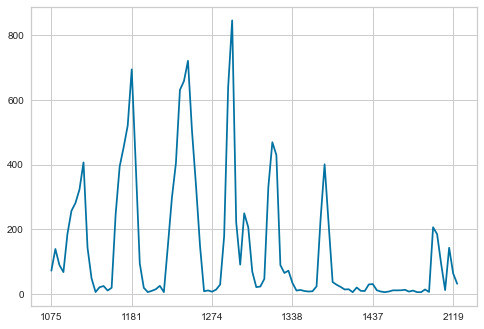

In [71]:
count_taxi.plot()

In [85]:
np.divide([1, 2, 3], [1, 2, 2] )

array([1. , 1. , 1.5])

In [87]:
def fill_model(model):
    for reg in model:
        reg_error = 0
        for i in range(juneEndindex - mayEndIndex - 4):
            predict_dy = model[reg].get_prediction(start=mayEndIndex+i, end=mayEndIndex+i+5, 
                                                     dynamic=True, 
                                                     exog=exogen_furrier.iloc[mayEndIndex+i:mayEndIndex+i+6])
            diffs = np.abs(df_large[mayEndIndex+i:mayEndIndex+i+6][reg].values - predict_dy.predicted_mean.values)
            reg_error = reg_error + np.divide(diffs, np.abs(df_large[mayEndIndex+i:mayEndIndex+i+6][reg].values)).sum()
            
            #reg_error = reg_error / df_large[str(reg)][mayEndIndex+i - 1]
        errors[int(reg)-1] = reg_error / (6 * (juneEndindex - mayEndIndex - 4))  #* count_taxi[str(reg)])

In [88]:
fill_model(model_0)
fill_model(model_1)
fill_model(model_2)
fill_model(model_3)
fill_model(model_4)
fill_model(model_5)

In [89]:
from mpl_toolkits.basemap import Basemap
import folium
import branca.colormap as cm

# Построим сетку для регионов
regions = pd.read_csv('regions.csv', sep=';')
longs, lats = np.meshgrid(np.unique(regions[['west', 'east']].values), 
                          np.unique(regions[['south', 'north']].values))

# Нью-Йорк вписан в прямоугольник
West = -74.25559
East = -73.70001
South = 40.49612
North = 40.91553

#Longitude of Empire State Building -73.985664
#Latitude of Empire State Building: 40.748441
ESB_long = -73.985664
ESB_lat  =  40.748441



Text(-73.985664, 40.748441, 'Empire State Building')

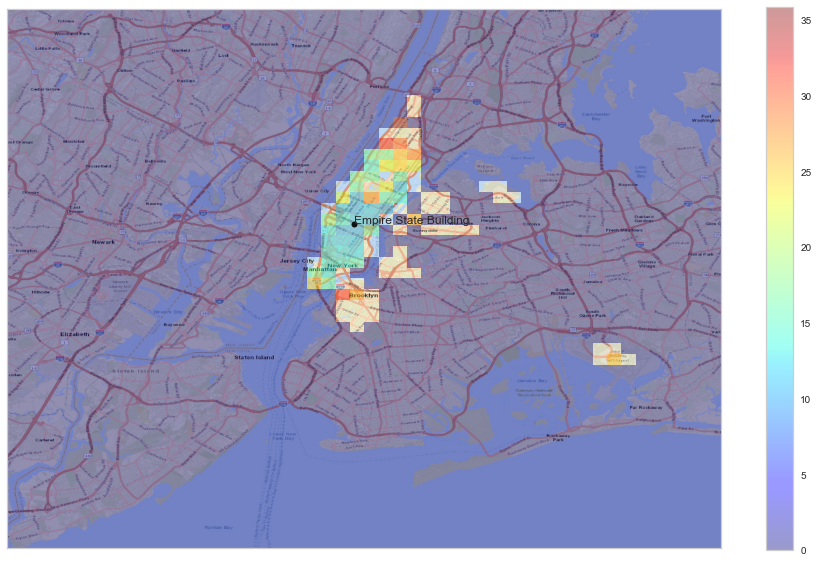

In [92]:
plt.figure(figsize=(16,10))

NY_map = Basemap(llcrnrlat = South, llcrnrlon = West, 
                 urcrnrlat = North, urcrnrlon = East,
                projection='lcc', resolution='i',
                lat_0 = (North+South)/2.0, lon_0 = (West+East)/2.0, 
                epsg=4326)

NY_map.pcolormesh(longs, lats, 100*np.array(errors).reshape(50,50).transpose(), cmap='jet', alpha=0.4, )
plt.colorbar()

NY_map.arcgisimage(service="World_Street_Map", xpixels=1200, epsg=4362, dpi=500)

x, y = NY_map(ESB_long, ESB_lat)
plt.plot(x, y, 'ok', markersize=6)
plt.text(x, y, 'Empire State Building', fontsize=12)
